# Parameter tests

Tests for self-reliance, attitude, and fixed attitude influence

In [1]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

BINARY_CLUSTER_BINS = np.arange(0, 1, 0.5)

In [136]:
location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

files = []
for fname in os.listdir(location):
    if ".0" in fname and "_mode" in fname:        
        files.append(os.path.join(location, fname))
        
print(files[-1])


..\data\paramstest\agent_data_constant-avantgarde_mode-1.00.csv


In [137]:
def find_file(key, val, m):
    for file in files:
        if val in file and m in file and key in file:
            return file

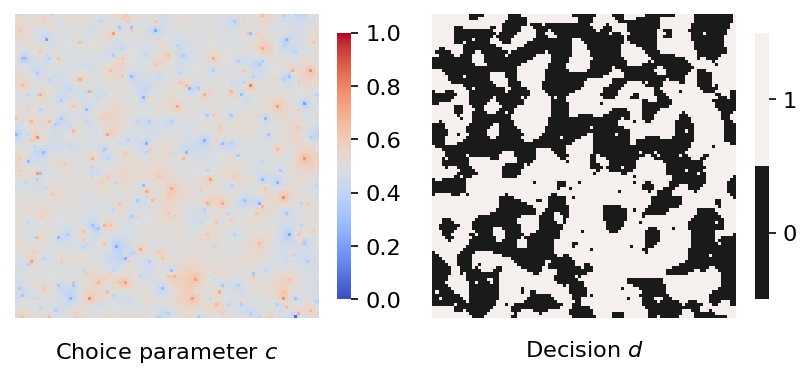

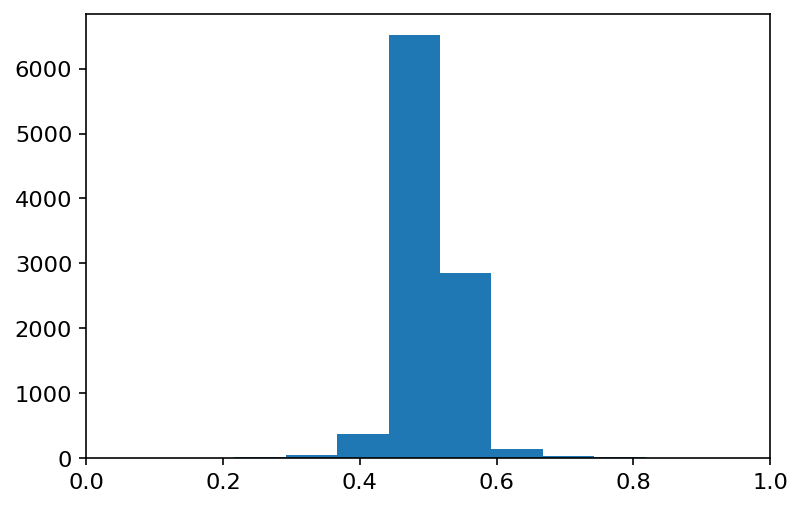

In [138]:
# show file
file = find_file("goal", "mode-0.5", "10.")
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

finalstep = 100

xseed = 100
sample = data.query("seed == @xseed")

ShowState(Grid(Choice(sample, finalstep)))

plt.figure()
plt.hist(sample.query("step == @finalstep").get("affinity"), bins=10)
plt.xlim([0, 1])
plt.show()

In [139]:
# show file
file = find_file("goal", "mode-0.5", "10.")
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

finalstep = 100

xseed = 100
sample = data.query("seed == @xseed")

N = 100
Aii = sample.query("step == @finalstep").get("affinity").values
decisions = np.int32(Aii.reshape(N, N) >= 0.5)
unique = np.unique(decisions)

row_indices, col_indices = np.where(decisions == 0)
indices = list(zip(row_indices, col_indices))

def get_neighbour_indices(i, j, Nx, Ny):
    """
    Returns the list of neighboring indices for a cell at position (i, j)
    in a 2D grid with periodic boundary conditions and dimensions Nx x Ny.
    """
    di_values = [-1, 0, 1]
    dj_values = [-1, 0, 1]
    neighbours = [((i+di) % Nx, (j+dj) % Ny)
                 for di in di_values
                 for dj in dj_values
                 if di != 0 or dj != 0]
    return neighbours

def count_neighbours(index_list, Nx, Ny):
    """
    Counts the number of neighbors for each index in a list of 2D indices
    with periodic boundary conditions and dimensions Nx x Ny.
    """
    index_set = frozenset(index_list)
    neighbours = [0] * len(index_list)
    for i, index in enumerate(index_list):
        neighbour_indices = get_neighbour_indices(index[0], index[1], Nx, Ny)
        neighbour_set = frozenset(neighbour_indices)
        count = len(neighbour_set.intersection(index_set))
        #count = sum(1 for ni, nj in neighbour_indices if list((ni, nj)) in index_list)
        neighbours[i] = count
    return neighbours

def mean_degree(data, decision, finalstep=100):
    if type(data) == pd.DataFrame:
        Aii = data.query("step == @finalstep").get("affinity").values
    else:
        Aii = data
    N = 100
    Na = 8
    decisions = np.int32(Aii.reshape(N, N) >= 0.5)
    row_indices, col_indices = np.where(decisions == decision)
    indices = list(zip(row_indices, col_indices))
    links = count_neighbours(indices, N, N)
    return np.mean(links) / Na

mean_degree(sample, 0)

0.842568866111467

In [17]:
%%timeit
counts = count_neighbours(indices, N, N)

39 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [317]:
def connectivity(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    noise_count_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
    sizes_ = counts_[unique_labels_ >= 0]
    n_clusters = sizes_.size
    n_agents = np.sum(counts_[unique_labels_ >= -1])
    if n_agents <= 1: return -1
    return (n_agents - (n_clusters + noise_count_)) / (n_agents - 1)

In [801]:
# Compare cluster connectivity with degree connectivity
# -----------------------------------------------------
import numpy as np
from BlockNNClustering import *

def connectivity(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    noise_count_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
    sizes_ = counts_[unique_labels_ >= 0]
    n_clusters = sizes_.size
    n_agents = np.sum(counts_[unique_labels_ >= -1])
    return (n_agents - (n_clusters + noise_count_)) / (n_agents - 1)


# (a) timeline
################
# arrange
cluster_builder = BlockNNClustering()
t = np.arange(0, 40, 2)

N = 100
# load data
stack = []
seeds = [i for i in range(100, 109)]
for seed in seeds:
    file = f"../data/uniform/data_A_seed{seed}.csv"
    attitudes = np.genfromtxt(file, delimiter=' ')
    #print(f"Shape: {attitudes.shape}")

    stack_ = []
    for ti in t:
        Aii = attitudes[ti]
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)
        _, (pos, neg) = cluster_builder.fit(decisions)
        cpos = connectivity(pos)
        cneg = connectivity(neg)
        mdpos = mean_degree(Aii, 1)
        mdneg = mean_degree(Aii, 0)
        stack_.append([cpos, cneg, mdpos, mdneg])

    stack.append(stack_)

# save data
stack = np.array(stack)

In [802]:
# (b) individuality
####################
x = []
N = 100
concentration = "10.0"
parameter = "avantgarde"
        
# select files
location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

files = []
for fname in os.listdir(location):
    if f"-{parameter}" in fname and "_mode" in fname:
        if fname.split("concentration-")[1].split(".csv")[0] == concentration and \
            np.round(float(fname.split("mode-")[1].split("_concentration")[0]), 1) in np.round(np.arange(0.1, 0.91, 0.05), 2):
            files.append(os.path.join(location, fname))

# load data
stack2 = []
for file in files:
    data = LoadSimulation(file, columns=columns)
    
    # calculate properties
    x.append(data.query("step == 0").get("avantgarde").mean())

    # get clusters
    stack2_ = []
    for seed, df in data.query("step == 100").groupby("seed"):
        if int(seed) not in seeds:
            continue
            
        Aii = df.get("affinity").values
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)
        _, (pos, neg) = cluster_builder.fit(decisions)
        cpos = connectivity(pos)
        cneg = connectivity(neg)
        mdpos = mean_degree(Aii, 1)
        mdneg = mean_degree(Aii, 0)
        stack2_.append([cpos, cneg, mdpos, mdneg])

    stack2.append(stack2_)

# save
stack2 = np.array(stack2)

In [803]:
means, stderr = [], []
for i, _ in enumerate(t):
    means.append(stack[:,i].mean(axis=0))
    stderr.append(stack[:,i].std(axis=0) / np.sqrt(10))
    
means = np.array(means)
stderr = np.array(stderr)

means2, stderr2 = [], []
for i, _ in enumerate(x):
    means2.append(stack2[i,:].mean(axis=0))
    stderr2.append(stack2[i,:].std(axis=0) / np.sqrt(10))
    
means2 = np.array(means2)
stderr2 = np.array(stderr2)

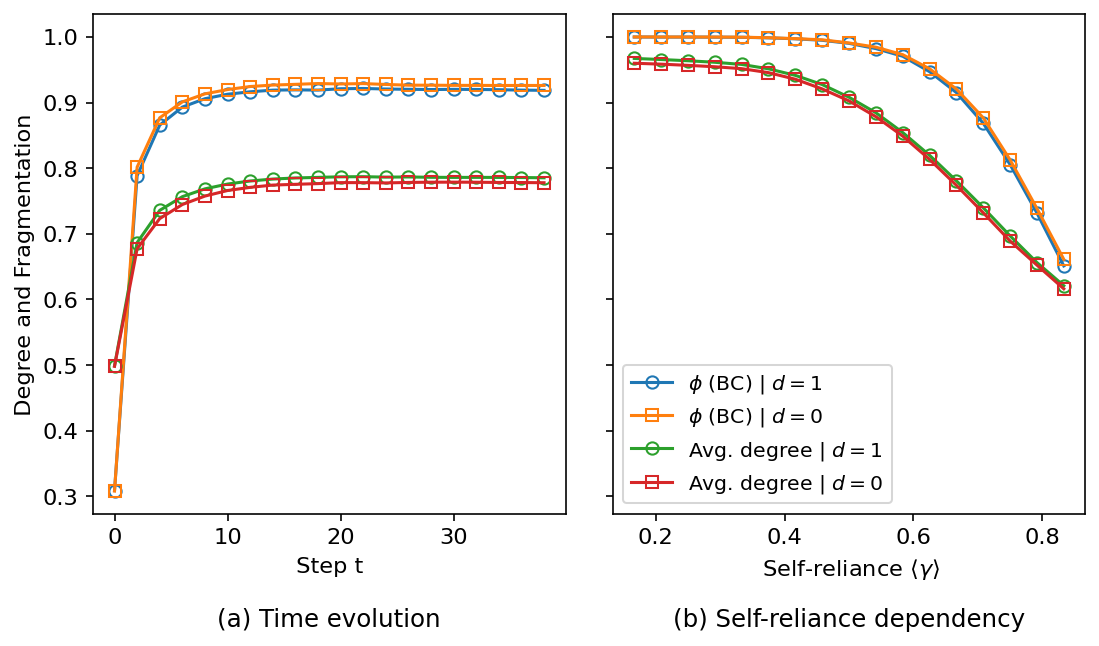

In [812]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)
plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

ax1.errorbar(t[:], means[:,0][0:], marker='o', mfc='none', label=" \n " + r"$d=1$")
ax1.errorbar(t[:], means[:,1][0:], marker='s', mfc='none', label="Block clustering \n " + r"$d=0$")
ax1.errorbar(t[:], means[:,2][0:], marker='o', mfc='none', label="Avg. degree \n "+r"$d=1$")
ax1.errorbar(t[:], means[:,3][0:], marker='s', mfc='none', label="Avg. degree \n "+r"$d=0$")

ax2.errorbar(x, means2[:,0], marker='o', mfc='none', label=r"$\phi$ (BC) | $d=1$")
ax2.errorbar(x, means2[:,1], marker='s', mfc='none', label=r"$\phi$ (BC) | $d=0$")
ax2.errorbar(x, means2[:,2], marker='o', mfc='none', label=r"Avg. degree | $d=1$")
ax2.errorbar(x, means2[:,3], marker='s', mfc='none', label=r"Avg. degree | $d=0$")

ax1.set_ylabel(" Degree and Fragmentation ")
ax1.set_xlabel(" Step t ")
ax2.set_xlabel(r" Self-reliance $\langle \gamma \rangle$ ")

lables, handles = ax2.get_legend_handles_labels()
ax2.legend(lables, handles, loc="best", fontsize=10)
#ax2.legend(loc="best", fontsize=10)
fig.subplots_adjust(right=0.8, wspace=0.1)

ax1.set_title("(a) Time evolution", y=-0.25, loc="center", fontsize=12)
ax2.set_title("(b) Self-reliance dependency", y=-0.25, loc="center", fontsize=12)

plt.show()

In [140]:
import numpy as np

def calculate_average_cells(N, M, r):
    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    grid[np.unravel_index(indices, (N, N))] = 1
    avg_cells = 0
    for i in range(N-M+1):
        for j in range(N-M+1):
            subgrid = grid[i:i+M, j:j+M]
            avg_cells += np.sum(subgrid)
    avg_cells /= (N-M+1)**2
    return avg_cells


def get_avg_degree(N, r):
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    indices = np.unravel_index(indices, (N, N))
    indices = list(zip(indices[0], indices[1]))
    return np.mean(count_neighbours(indices, N, N)) / 8


def calc_connectivity(N, r):
    if r == 0:
        return 0.;
    elif r == N:
        return 1.;
    
    my_clustering = BlockNNClustering()
    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    if r == 1:
        indices = [indices]
    grid[np.unravel_index(indices, (N, N))] = 1
    _, labels = my_clustering.fit(grid)
    if len(labels) == 1:
        return 1.
    neg, pos = labels
    return connectivity(pos)

def add_connectivities(N, k, n_loops, bcc_dict, avgdeg_dict):
    get_mean_stderr = lambda x: [np.mean(x), np.std(x) / np.sqrt(n_loops)]

    # initialize arrays
    conn_bcc = []
    conn_avgdeg = []
    for kj in k:
        results_bcc = [calc_connectivity(N, kj) for _ in range(n_loops)]
        results_avgdeg = [get_avg_degree(N, kj) for _ in range(n_loops)]

        conn_bcc.append(get_mean_stderr(results_bcc))
        conn_avgdeg.append(get_mean_stderr(results_avgdeg))

    bcc_dict[N] = np.array(conn_bcc)
    avgdeg_dict[N] = np.array(conn_avgdeg)

In [132]:
np.random.choice(np.arange(100), size=1, replace=False)

array([43])

In [145]:
np.array(k_rel * N*N, dtype=int)

array([ 0,  0,  1,  1,  2,  3,  3,  4,  5,  5,  6,  7,  7,  8,  8,  9, 10,
       10, 11, 12, 12, 13, 14, 14, 15, 16, 16, 17, 17, 18, 19, 19, 20, 21,
       21, 22, 23, 23, 24, 25])

In [141]:
k = np.append(np.arange(100, 10000, 2000), 10000)

if "bcc" not in globals():
    bcc = dict()
if "avgdeg" not in globals():
    avgdeg = dict()

k_rel = np.linspace(0, 1.0, 40)
for N in (50, 100, 150):
    k = np.array(k_rel * N*N, dtype=int)
    n_loops = 6
    add_connectivities(N, k, n_loops, bcc, avgdeg)

C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [142]:
# real connectivity of graph
N = 100
k = np.array(k_rel * N*N, dtype=int)
n_loops = 6
    
def get_avg_degree(N, r):
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    indices = np.unravel_index(indices, (N, N))
    indices = list(zip(indices[0], indices[1]))
    return np.mean(count_neighbours(indices, N, N)) / 8


In [143]:
xi, yi = 2, 0
xj, yj = 3, 3
N = 4
dx = abs(xi - xj)
dy = abs(yi - yj)
dx = N - dx
dx

3

The degree of connectivity of the grid graph with 12 agents is 2
The average degree of the graph is: {2: 5.0, 4: 4.5, 5: 4.36, 3: 4.777777777777778, 6: 4.333333333333333}


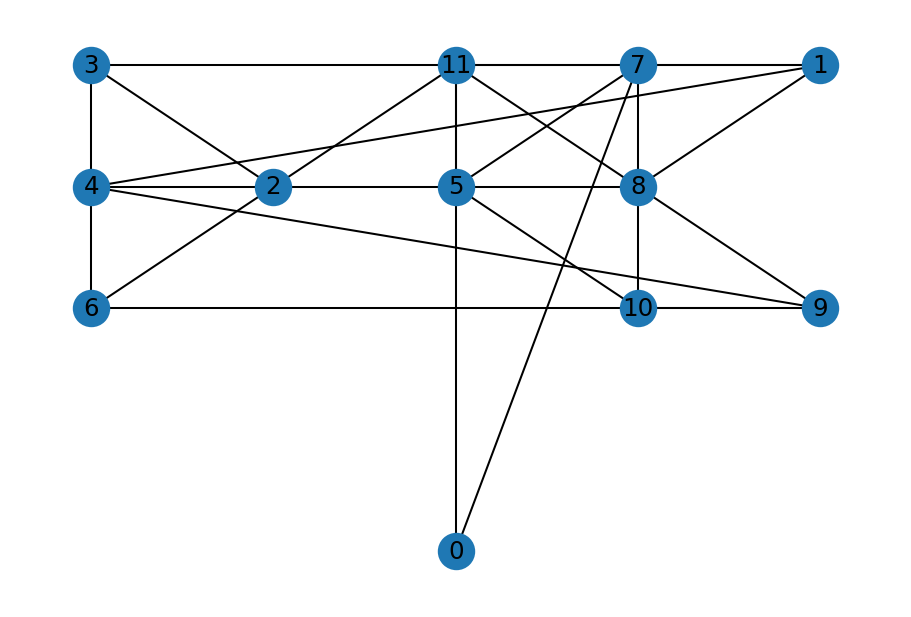

In [144]:
import networkx as nx
import random

def create_rnd_graph(N, k):
    # Create an empty graph
    G = nx.Graph()

    # Generate random locations for the agents on the grid
    locations = random.sample(range(N*N), k)

    # Add the nodes to the graph and assign their locations
    for i, loc in enumerate(locations):
        x = loc % N
        y = loc // N
        G.add_node(i, pos=(x, y))

    # Add edges between neighboring agents using the chessboard metric
    for i in range(k):
        for j in range(i+1, k):
            xi, yi = G.nodes[i]['pos']
            xj, yj = G.nodes[j]['pos']
            dx = abs(xi - xj)
            dy = abs(yi - yj)
            if dx <= 1 and dy <= 1 and dx + dy > 0:
                G.add_edge(i, j)

            # periodic boundary conditions
            dx = min(dx, N - dx)
            dy = min(dy, N - dy)
            if max(dx, dy) == 1:
                G.add_edge(i, j)
                
    return G

# Define the dimensions of the grid and the number of agents
N = 5
k = 12
G = create_rnd_graph(N, k)

# Visualize the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, with_labels=True)

# Calculate the degree of connectivity of the graph
degree_of_connectivity = nx.node_connectivity(G)
print("The degree of connectivity of the grid graph with {} agents is {}".format(k, degree_of_connectivity))

# Calculate the average degree of the graph
avg_degree = nx.average_degree_connectivity(G)
print("The average degree of the graph is:", avg_degree)

In [377]:
N = 10
k = np.array(k_rel * N*N, dtype=int)
n_loops = 6
avg_degree = []
node_conn = []
for ki in k[1:]:
    if ki < 1: 
        avg_degree.append([0,0])
        node_conn.append([0,0])
        continue
    dd = []
    cc = []
    for _ in range(n_loops):
        g = create_rnd_graph(N, ki)
        d = sum(dict(g.degree()).values()) / len(g)
        c = nx.node_connectivity(g)
        dd.append(d)
        cc.append(c)
    avg_degree.append([np.mean(dd), np.std(dd) / np.sqrt(len(dd))])
    node_conn.append([np.mean(cc), np.std(cc) / np.sqrt(len(cc))])
    
    
avg_degree = np.array(avg_degree)
node_conn = np.array(node_conn)

In [171]:
N = 100
k = np.array(k_rel * N*N, dtype=int)
doi_rnd = []
for ki in k[1:]:
    dd = []
    for i in range(n_loops):
        grid = np.zeros((N, N))
        indices = np.random.choice(np.arange(N*N), size=ki, replace=False)
        grid[np.unravel_index(indices, (N, N))] = 1
        dd.append(density_of_interfaces(grid.flatten()))
    doi_rnd.append([np.mean(dd), np.std(dd) / np.sqrt(len(dd))])

doi_rnd = np.array(doi_rnd)

In [168]:
k_rel.size

40

In [167]:
avg_degree[:,0].size

40

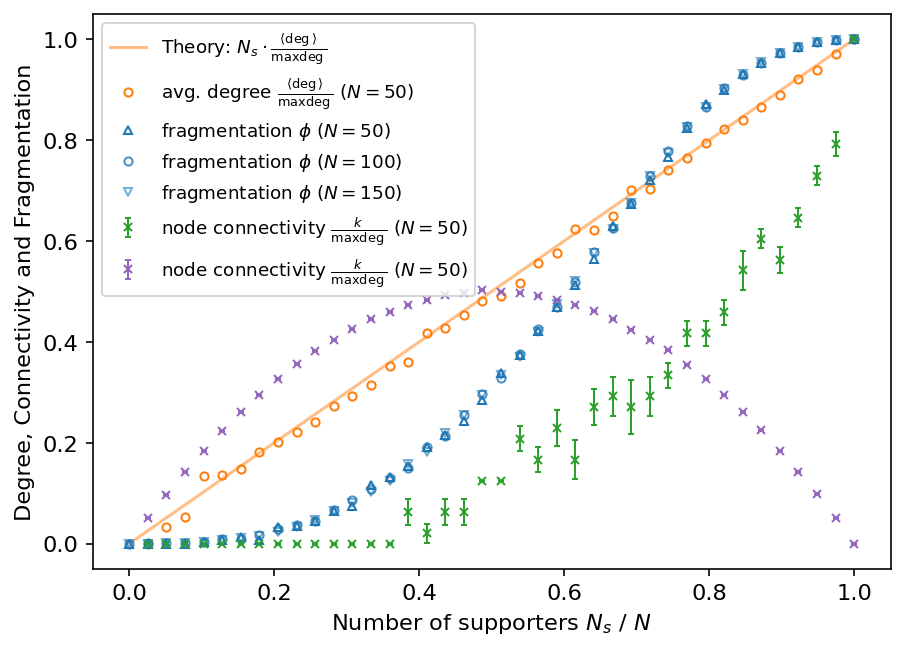

In [378]:
from scipy.optimize import curve_fit

plt.rcParams.update({"font.size": 11, "figure.dpi": 147})

fig, ax = plt.subplots(figsize=(7, 5))

ax.errorbar(k_rel[1:], avg_degree[:,0] / 8, ms=4, marker='o', mfc='none', linestyle="",color="tab:orange", label=r"avg. degree $\frac{\langle\deg\rangle}{\max\deg}$ ($N=50$)")
#ax.errorbar(k_rel, avgdeg[100][:,0], marker='o', mfc='none', linestyle="",color="tab:orange", label=r"Simulation avg. degree")

ax.errorbar(k_rel, bcc[50][:,0], ms=4, marker='^', mfc='none', color="tab:blue", linestyle="", label=r"fragmentation $\phi$ ($N=50$)")
ax.errorbar(k_rel, bcc[100][:,0], ms=4, marker='o', mfc='none', alpha=0.8, color="tab:blue", linestyle="", label=r"fragmentation $\phi$ ($N=100$)")
ax.errorbar(k_rel, bcc[150][:,0], ms=4, marker='v', mfc='none', alpha=0.6, color="tab:blue", linestyle="", label=r"fragmentation $\phi$ ($N=150$)")

ax.plot(k_rel, k_rel,color="tab:orange", alpha=0.5, label=r"Theory: $N_s \cdot \frac{\langle \deg \rangle}{\max \deg}$")


ax.errorbar(k_rel[1:], node_conn[:,0] / 8, yerr=node_conn[:,1]/8, marker='x', ms=4, elinewidth=1., capsize=1.5, linestyle="",color="tab:green", label=r"node connectivity $\frac{k}{\max\deg}$ ($N=50$)")
ax.errorbar(k_rel[1:], doi_rnd[:,0], yerr=doi_rnd[:,1], marker='x', ms=4, elinewidth=1., capsize=1.5, linestyle="",color="tab:purple", label=r"node connectivity $\frac{k}{\max\deg}$ ($N=50$)")

ax.legend(fontsize=9)
ax.set_xlabel(r"Number of supporters $N_s\ /\ N$")
ax.set_ylabel("Degree, Connectivity and Fragmentation")
#ax.set_title("", y=-0.25)

plt.show()

In [360]:
def sigmoid(x, x0, a):
    return 1 / (1 + np.exp(-a * (x - x0)))

# Generate some sample data
x_data = k_rel
y_data = bcc[100][:,0] #sigmoid(x_data, 0, 1) + 0.1 * np.random.randn(len(x_data))

# Fit the logistic function to the data
initial_guess = [0, 1]  # Initial guess for x0 and k
fit_params, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess)

# Extract the fitted parameter values
x0_fit = fit_params[0]
k_fit = fit_params[1]

# Print the fitted parameter values
print("x0_fit =", x0_fit)
print("k_fit =", k_fit)

x0_fit = 0.5954524253188423
k_fit = 8.81523805296111


[ 9.00600159e-03 -2.05141586e+01  1.84095980e+00  8.06281703e+00
  4.75937303e+00  5.28521246e+00]


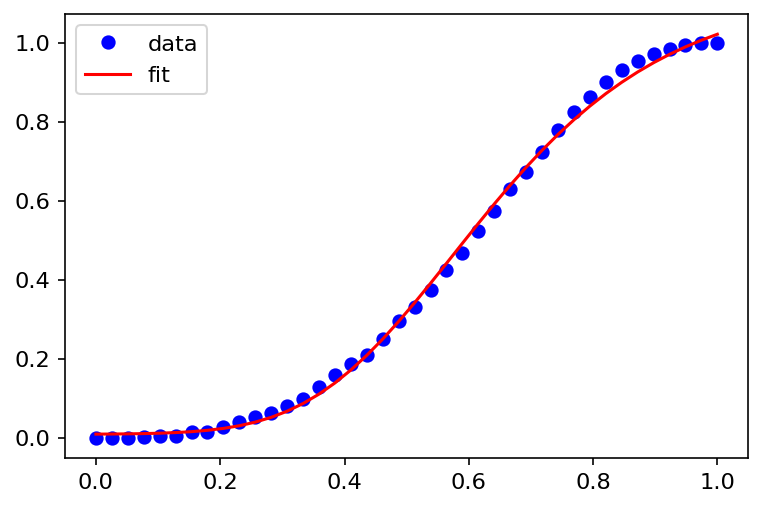

In [458]:
import numpy as np
from scipy.optimize import minimize

# Define the generalized logistic function
def gen_logistic(x, a, b, c, d, e, k):
    return a + (a-b) / (c + d*np.exp(-k*x))**e
    return a + (d - a) / (c + np.exp(-d*x))**(1/k)
    return a + (d - a) / ((1 + (x / c)**b)**k)

# Define the upper and lower asymptotes
upper_asymptote = 1
lower_asymptote = 0

# Define the custom penalty function
def penalty(params):
    # Extract the fitting parameters
    a, b, c, d, e, k = params
    
    # Apply penalty if the upper and lower asymptotes are violated
    penalty = 0
    u = a + (k-a)/c**e
    if u > upper_asymptote:
        penalty += (u - upper_asymptote)**4
    if a < lower_asymptote:
        penalty += (lower_asymptote - a)**4
    
    penalty += (0.95-gen_logistic(1., *params))**2
    return penalty

# Define the objective function to minimize
def objective(params, x, y):
    # Compute the sum of squared residuals between the data and the model
    residuals = y - gen_logistic(x, *params)
    ssr = np.sum(residuals**2)
    
    # Apply the penalty to the objective function
    penalty_value = penalty(params)
    return ssr + penalty_value

# Generate some sample data
xdata = np.linspace(0, 10, num=50)
xdata, ydata = k_rel, bcc[100][:,0]

# Set the initial guess for the fitting parameters
params0 = [0.1, 1, 1, 0.9, 1, 1.]

# Minimize the objective function with the custom penalty
result = minimize(objective, params0, args=(xdata, ydata), method='Nelder-Mead')

print(result.x)

# Extract the fitted parameters
a_fit, b_fit, c_fit, d_fit, e_fit, k_fit = result.x

# Plot the fitted function
import matplotlib.pyplot as plt
plt.plot(xdata, ydata, 'bo', label='data')
plt.plot(xdata, gen_logistic(xdata, a_fit, b_fit, c_fit, d_fit, e_fit, k_fit), 'r-', label='fit')
plt.legend()
plt.show()


In [521]:
@dataclass
class ClusterProperty:
    noise_count: int
    cluster_count: int
    sizes: np.ndarray
    

def fit_block_clusters_on_random_state(N, r):
    # check if only one decision
    if r < 1:
        return [np.ones((N,N))*(-2), np.zeros((N,N))]
    elif r == N*N:
        return [np.zeros((N,N)), np.ones((N,N))*(-2)]

    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    grid[np.unravel_index(indices, (N, N))] = 1
    my_clustering = BlockNNClustering(min_cluster_size=1)
    _, labels = my_clustering.fit(grid)
    return labels

def get_cluster_property(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    noise_count_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
    sizes_ = counts_[unique_labels_ >= 0]
    n_clusters = sizes_.size
    return ClusterProperty(noise_count_, n_clusters, sizes_)


r = 1000
N = 100

neg, pos = fit_block_clusters_on_random_state(N, r)
cp = get_cluster_property(pos)
#cn = get_cluster_property(neg)


print(cp)

ClusterProperty(noise_count=996, cluster_count=1, sizes=array([4], dtype=int64))


In [525]:
def main_block_clusters_random_state(N, rr, n_loops):
    cluster_properties = []
    for r in rr:
        tmp_ = []
        for _ in range(n_loops):
            neg, pos = fit_block_clusters_on_random_state(N, r)
            cp = get_cluster_property(pos)
            tmp_.append(cp)
        cluster_properties.append(tmp_)
    return cluster_properties

    
rr = np.arange(1000, 10000, 1000)
n_loops = 3
N = 100

results = main_block_clusters_random_state(N, rr, n_loops)

<ErrorbarContainer object of 3 artists>

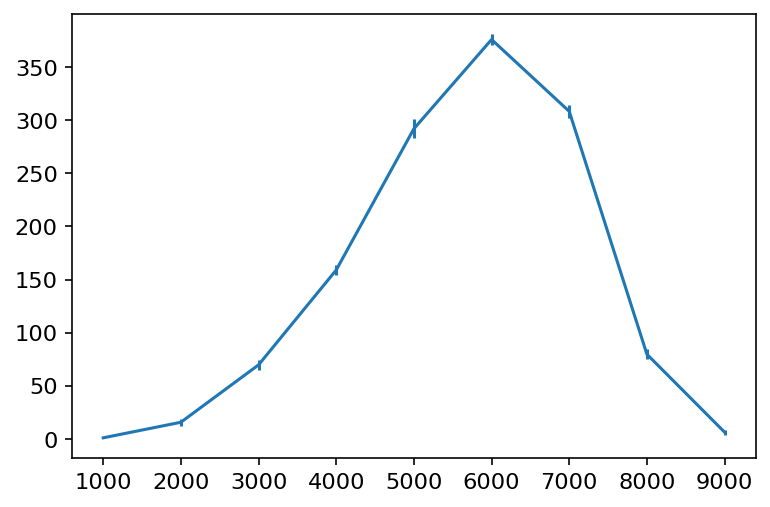

In [529]:
x = rr
y = [np.mean([props.sizes.size for props in props_list]) for props_list in results]
yerr = [np.std([props.sizes.size for props in props_list]) for props_list in results]

plt.errorbar(x, y, yerr=yerr)

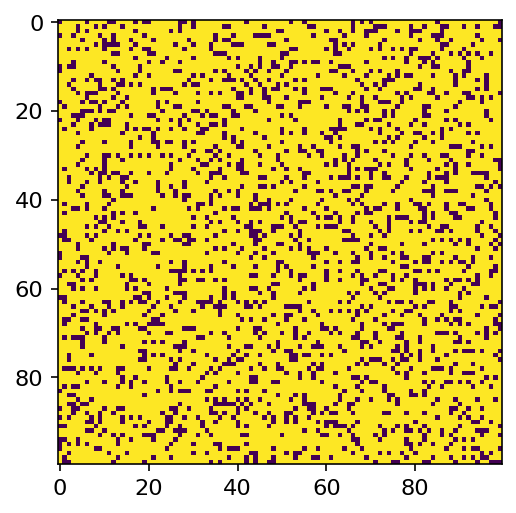

In [519]:
grid = np.zeros((N, N))
indices = np.random.choice(np.arange(N*N), size=8000, replace=False)
grid[np.unravel_index(indices, (N, N))] = 1
plt.imshow(grid)

In [191]:
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]

In [192]:
def theta(x):
    if x >= 0.:
        return 1
    else:
        return 0

In [193]:
plot_data = {}

keys = ("avantgarde", "affinityGoal", "affinity")
fkeys = ("avantgarde", "goal", "affinity")
for num in ("10.0", "5.0"):
    plot_data[num] = {}
    
    for (key, fkey) in zip(keys, fkeys):

        # select files
        location = "..\data\paramstest"
        file = "agent_beta-avantgarde_"

        files = []
        for fname in os.listdir(location):
            if f"-{num}" in fname and f"-{fkey}" in fname \
                and "_mode" in fname:        
                files.append(os.path.join(location, fname))

        # load data
        x, means, stds, modes, di = [], [], [], [], []
        for file in files:
            data = LoadSimulation(file, columns=columns)

            # calculate properties
            modes.append(float(file.split("mode-")[1].split("_")[0]))
            xi = data.query("step == 0").get(key).mean()
            m = data.query("step == @finalstep").groupby("seed").mean().get("affinity")
            std = data.query("step == @finalstep").groupby("seed").std().get("affinity")
            decision_imbalance = data.query("step == @finalstep").groupby("seed")\
                .apply(lambda x: (x.apply(lambda r: theta(r["affinity"]-0.5)-theta(0.5-r["affinity"]), axis=1)).sum())\
            
            x.append(xi)
            means.append(m)
            stds.append(std)
            di.append(decision_imbalance)

        # save
        plot_data[num][key] = {"x": x, "m": means, "std": stds, "mode": modes, "di": di}

In [196]:
## Get uniform properties
##########################
file_uniform = "../data/distributions/agent_data_1000steps.csv"
data_uniform = LoadSimulation(file_uniform, columns=["step", "id", "affinity", "avantgarde", "affinityGoal", "seed"])

uni_ams = []
Am = []
Astdm = []
for seed in seeds:
    sample = data_uniform.query("step==1000").query("seed == @seed")
    decision_grid = np.array(sample.get("affinity").values.reshape(100, 100) >= 0.5, dtype="int")
    uni_ams.append(AnalyzedModelState.build(decision_grid))
    Am.append(np.mean(sample.get("affinity").values))
    Astdm.append(np.std(sample.get("affinity").values))

uni_attitude = (np.mean(Am), np.std(Am))
uni_attitude_std = (np.mean(Astdm), np.std(Astdm))
uni_fragmentation = (np.mean([x.fragmentation for x in uni_ams]), np.std([x.fragmentation for x in uni_ams]))
uni_cluster_size = (np.mean([x.mean_size for x in uni_ams]), np.std([x.mean_size for x in uni_ams]))
uni_cluster_count = (np.mean([x.cluster_count for x in uni_ams]), np.std([x.cluster_count for x in uni_ams]))
uni_doi = (np.mean([x.density_of_interfaces for x in uni_ams]), np.std([x.density_of_interfaces for x in uni_ams]))

In [225]:
uni_m = (np.mean([x.magnetisation for x in uni_ams]), np.std([x.magnetisation for x in uni_ams]))
uni_m

(0.002579591836734693, 0.04303187702912493)

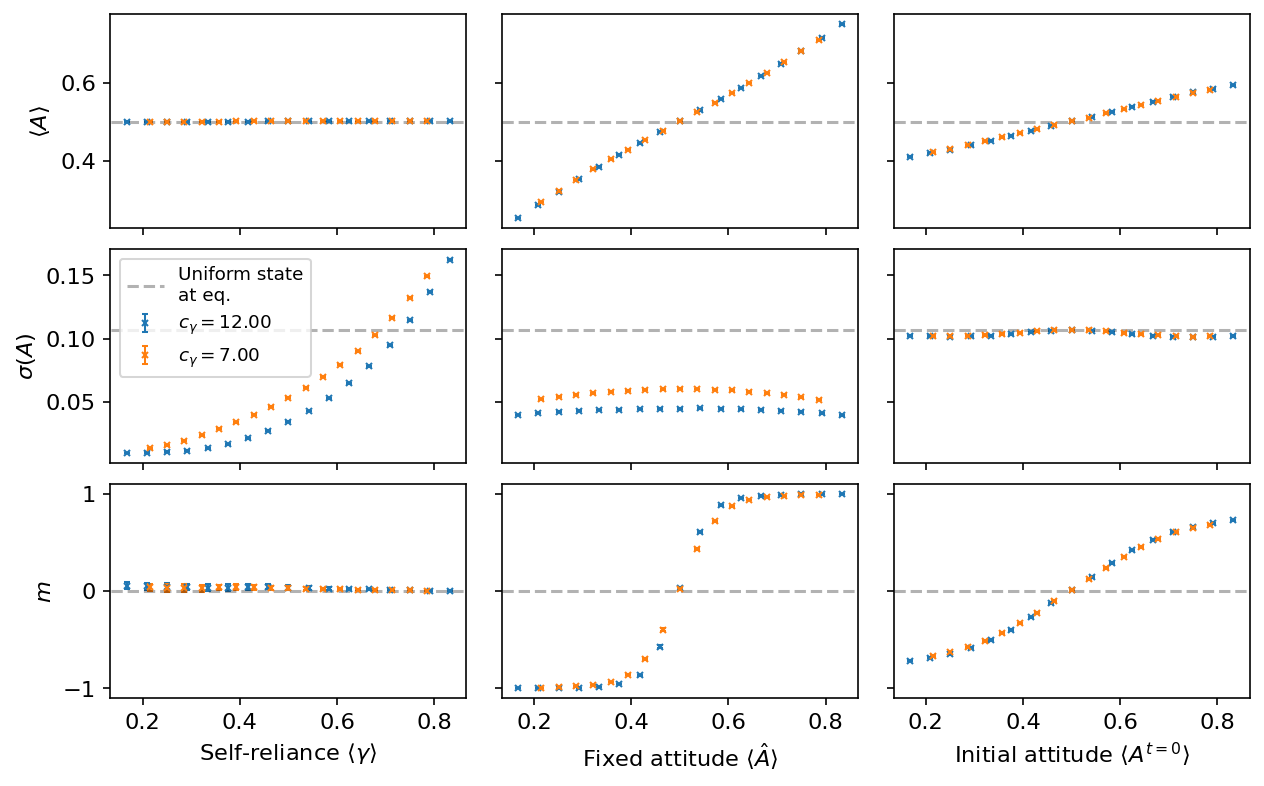

In [229]:
fig, ax = plt.subplots(3, 3, sharey="row", sharex="col", figsize=(10, 6))

plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

labels = (r"Self-reliance $\langle \gamma \rangle$", 
          r"Fixed attitude $\langle \hat{A} \rangle$", 
          r"Initial attitude $\langle A^{t=0} \rangle$")
signs = ("{\gamma}", "{\hat{A}}", "{A^{t=0}}")
# plot mean
for i, axis in enumerate(ax[0]):
    key = keys[i]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean() for _x in _data[key]["m"]], 
                      yerr=[_x.std()/np.sqrt(_x.size) for _x in _data[key]["m"]], 
                      marker="x", ms=3, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
    axis.set_xlim(axis.get_xlim())
    axis.plot([0, 1], uni_attitude[0]*np.ones(2), linestyle="--", label="Uniform \nstate\n", color="black", alpha=0.3)

# plot variance
for i, axis in enumerate(ax[1]):
    key = keys[i]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean() for _x in _data[key]["std"]], 
                      yerr=[_x.std()/np.sqrt(_x.size) for _x in _data[key]["std"]],
                      marker="x", ms=3, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
    
    axis.set_xlim(axis.get_xlim())
    axis.plot([0, 1], uni_attitude_std[0]*np.ones(2), linestyle="--", label="Uniform state\nat eq.", color="black", alpha=0.3)

ax[1,0].legend(fontsize=9, loc="upper left", ncol=1)

# plot decision imbalance
for i, axis in enumerate(ax[2]):
    key = keys[i]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean()/ 10_000 for _x in _data[key]["di"]], 
                      yerr=[_x.std()/ 10_000/np.sqrt(_x.size) for _x in _data[key]["di"]],
                      marker="x", ms=3, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
    
    axis.set_xlim(axis.get_xlim())
    axis.plot([0, 1], uni_m[0]*np.ones(2), linestyle="--", label="Uniform state\nat eq.", color="black", alpha=0.3)
    axis.set_xlabel(labels[i], fontsize=11)

ax[0, 0].set_ylabel(r"$\langle A \rangle$")
ax[1, 0].set_ylabel(r"$\sigma(A)$")
ax[2, 0].set_ylabel(r"$m$")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# labels = [r"$c_X=12.0$", r"$c_X=7.0$"]
# legend_elements = [Line2D([0], [0], linestyle="", marker='o', markerfacecolor="tab:blue", markeredgecolor="black", markersize=10),
#                    Line2D([0], [0], linestyle="", marker='o', markerfacecolor="tab:orange", markeredgecolor="black", markersize=10),
#                    #Line2D([0], [0], linestyle="", marker='s', markerfacecolor="r", markeredgecolor="black", markersize=10)
#                   ]
# fig.legend(legend_elements, labels, loc='upper center', ncol=2)
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9)
plt.show()

In [230]:
import BlockNNClustering
reload(BlockNNClustering)
from BlockNNClustering import *

from dataclasses import *
import numpy as np

# Class for saving cluster information 
# of a single agent selection
@dataclass
class Clusters:
    noise_count: int
    sizes: np.ndarray
    
    @staticmethod
    def build(labels):
        unique_labels_, counts_ = np.unique(labels, return_counts=True)
        noise_count_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
        sizes_ = counts_[unique_labels_ >= 0]
        return Clusters(noise_count_, sizes_)
    
    def tolist(self): # includes noise
        size_list = self.counts[self.unique_labels >= 0].tolist()
        size_list.extend([1 for _ in range(self.n_noise)])
        return size_list
    
# Class for saving cluster information
# of a single state
@dataclass
class StateClusters:
    positive: Clusters
    negative: Clusters
        
    @staticmethod
    def build(all_labels):
        labels_neg_, labels_pos_ = all_labels
        pos_ = Clusters.build(labels_pos_)
        neg_ = Clusters.build(labels_neg_)
        return StateClusters(pos_, neg_)
    
@dataclass
class StateClusterStats:
    positive: list
    negative: list
    seeds: list
    
    @staticmethod
    def create():
        return StateClusterStats([], [], [])
    
    def add(self, state_clusters, seed):
        self.positive.append(state_clusters.positive)
        self.negative.append(state_clusters.negative)
        self.seeds.append(seed)
        
    def n(self, filtered=""):
        if filtered == "positive":
            return np.array([p_.n for p_ in self.positive])
        elif filtered == "negative":
            return np.array([n_.n for n_ in self.negative])
        else:
            return np.array(
                [c.n for c in self.positive]
                            .extend([n_.n for n_ in self.negative])
            )

In [231]:
block_clustering = BlockNNClustering(min_cluster_size=1)
cluster_data = {}
N = 100

keys = [("avantgarde", "avantgarde"), ("affinityGoal", "goal"), ("affinity", "affinity")]
for num in ("10.0", "5.0"):
    cluster_data[num] = {}
    
    for (key, fkey) in keys:

        # select files
        location = "..\data\paramstest"
        file = "agent_beta-avantgarde_"

        files = []
        for fname in os.listdir(location):
            if f"-{num}" in fname and f"-{fkey}" in fname \
                and "_mode" in fname:         
                files.append(os.path.join(location, fname))

        # load data
        x, clusters, modes = [], [], []
        for file in files:
            print(file)
            data = LoadSimulation(file, columns=columns)
            modes.append(float(file.split("mode-")[1].split("_")[0]))
            
            # calculate properties
            xi = data.query("step == 0").get(key).mean()
            scs = StateClusterStats.create()
            
            # get clusters
            for seed, df in data.query("step == 100").groupby("seed"):
                Aii = df.get("affinity").values
                decisions = np.int32(Aii.reshape(N, N) >= 0.5)
                unique = np.unique(decisions)
                if unique.size == 1:
                    is_pos = unique[0] == 1
                    if is_pos: 
                        pos = np.zeros(decisions.shape)
                        neg = np.ones(decisions.shape) * (-2)
                    else:
                        pos = np.ones(decisions.shape) * (-2)
                        neg = np.zeros(decisions.shape)
    
                    _, all_labels = (None, (neg, pos))
                else:
                    _, all_labels = block_clustering.fit(decisions)
                scs.add(StateClusters.build(all_labels), seed)
            
            x.append(xi)
            clusters.append(scs)

        # save
        cluster_data[num][key] = {"x": x, "mode": modes, "clusters": clusters}


..\data\paramstest\agent_data_beta-avantgarde_mode-0.10_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.15_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.20_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.25_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.30_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.35_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.40_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.45_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.50_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.55_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.60_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.65_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0

In [ ]:
file = "../data/paramstest/agent_data_beta-goal_mode-0.15_concentration-5.0.csv"
data = LoadSimulation(file, columns=columns)
            
# calculate properties
xi = data.query("step == 0").get(key).mean()

# get clusters
stat0, stat1 = [], []
for seed, df in data.query("step == 100").groupby("seed"):
    stat0.append(connectivity_real(df, 0))
    stat1.append(connectivity_real(df, 1))
    
print(xi)

In [232]:
def number_of_clusters(stats):
    return [c_.sizes.size for c_ in stats.positive]

def number_of_clusters_neg(stats):
    return [c_.sizes.size for c_ in stats.negative]

def connectivity_stats(stats):
    out = []
    for cluster in stats.positive:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

def connectivity_network(stats):
    out = []
    for cluster in stats.positive:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out
    

def connectivity_neg(stats):
    out = []
    for cluster in stats.negative:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

def noise_count(stats):
    return [c_.noise_count for c_ in stats.positive]

def noise_count_neg(stats):
    return [c_.noise_count for c_ in stats.negative]

N = 10_000
def avg_size(stats):
    return [c_.sizes.mean()/N if c_.sizes.any() else 0 for c_ in stats.positive]

def avg_size_neg(stats):
    return [c_.sizes.mean()/N if c_.sizes.any() else 0 for c_ in stats.negative]


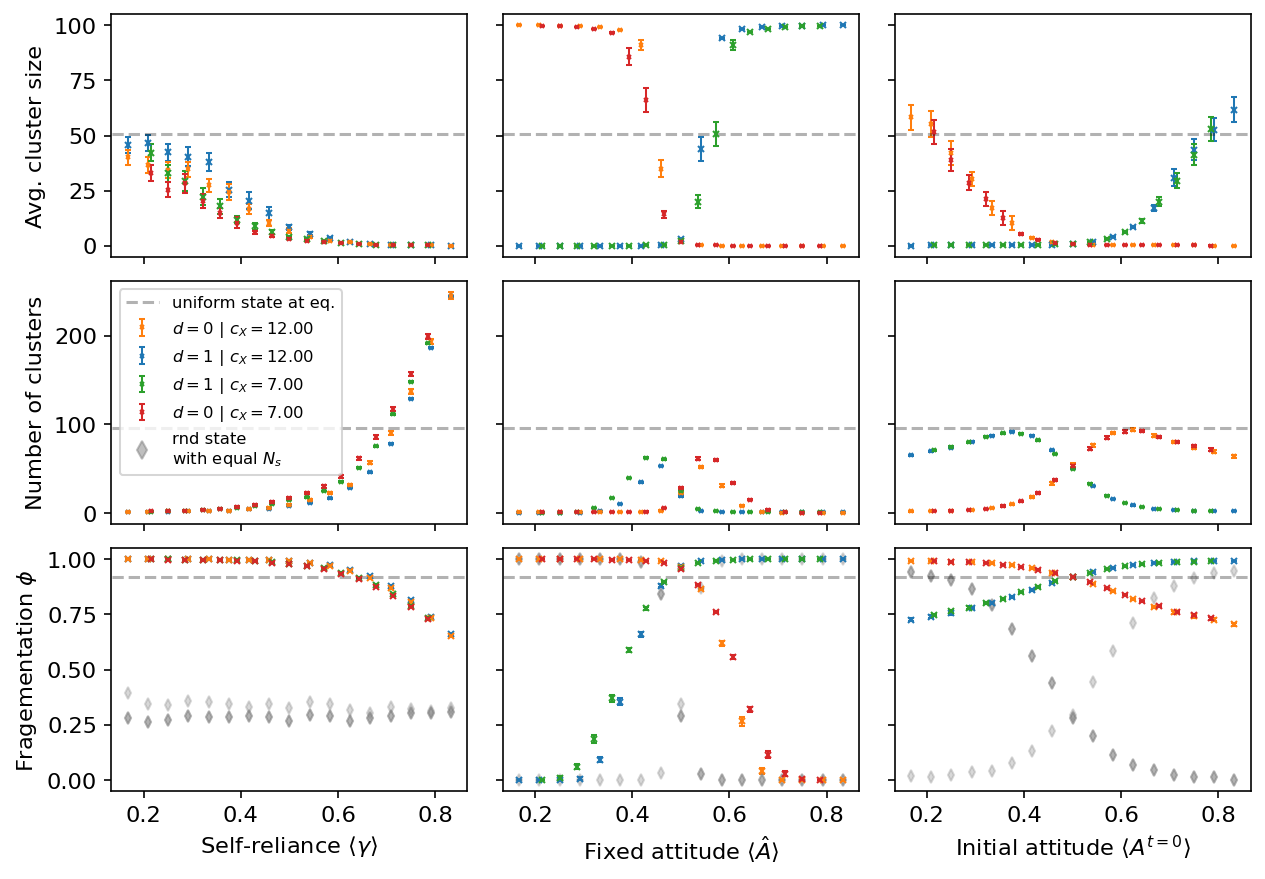

In [267]:
fig, ax = plt.subplots(3, 3, sharey="row", sharex="col", figsize=(10, 7))

plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

signs = ("{\gamma}", "{\hat{A}}", "{A^{t=0}}")
labels = (r"Self-reliance $\langle \gamma \rangle$", r"Fixed attitude $\langle \hat{A} \rangle$", r"Initial attitude $\langle A^{t=0} \rangle$")
# plot mean
for i, axis in enumerate(ax[1]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [number_of_clusters(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_)/len(x_) for x_ in n_clusters], 
                      marker="x", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$d=1\ |\ c_X={float(num)+2:.2f}$")
        
        n_clusters = [number_of_clusters_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_)/np.sqrt(len(x_)) for x_ in n_clusters], 
                      marker="x", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$d = 0\ |\ c_X={float(num)+2:.2f}$")
        
#         if num == "10.0":
#             axis.plot(x, [cluster_count_from_labels(x[0]) for x in rnd_labels[key][num]], 
#                       c="gray", alpha=0.6, linestyle="", marker="d", ms=4)

#             axis.plot(x, [cluster_count_from_labels(x[1]) for x in rnd_labels[key][num]], 
#                       c="gray", alpha=0.3, linestyle="", marker="d", ms=4)
        
    axis.set_xlim(axis.get_xlim())
    axis.plot([0, 1], uni_cluster_size[0]*np.ones(2), linestyle="--", color="black", alpha=0.3, label="uniform state at eq.")

# plot variance
for i, axis in enumerate(ax[2]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [connectivity_stats(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_)/np.sqrt(len(x_)) for x_ in n_clusters], 
                      marker="x", ms=3, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = [connectivity_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_)/np.sqrt(len(x_)) for x_ in n_clusters], 
                      marker="x", ms=3, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        axis.set_xlabel(labels[i], fontsize=11)

        if num == "10.0":
            axis.plot(x, [connectivity_from_labels(x[0]) for x in rnd_labels[key][num]], 
                      c="gray", alpha=0.6,  linestyle="", marker="d", ms=4)

            axis.plot(x, [connectivity_from_labels(x[1]) for x in rnd_labels[key][num]], 
                      c="gray", alpha=0.3, linestyle="", marker="d", ms=4)

    axis.set_xlim(axis.get_xlim())
    axis.plot([0, 1], uni_fragmentation[0]*np.ones(2), linestyle="--", color="black", alpha=0.3, label="Uniform state at eq.")
        
# plot variance
for i, axis in enumerate(ax[0]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [avg_size(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_)/np.sqrt(len(x_)) for x_ in n_clusters], 
                      marker="x", ms=3, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = [avg_size_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_)/np.sqrt(len(x_)) for x_ in n_clusters], 
                      marker="x", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
    
#         if num == "10.0":
#             axis.plot(x, [mean_size_from_labels(x[0])/10_000 for x in rnd_labels[key][num]], 
#                       c="gray", alpha=0.6, linestyle="", marker="d", ms=4)

#             axis.plot(x, [mean_size_from_labels(x[1])/10_000 for x in rnd_labels[key][num]], 
#                       c="gray", alpha=0.3, linestyle="", marker="d", ms=4)
    
    axis.set_xlim(axis.get_xlim())
    axis.plot([0, 1], uni_cluster_count[0]*np.ones(2), linestyle="--", color="black", alpha=0.3, label="Uniform state at eq.")

ax[1, 0].set_ylabel(r"Number of clusters")
ax[2, 0].set_ylabel(r"Fragementation $\phi$")
ax[0, 0].set_ylabel("Avg. cluster size")

marks, labels = ax[1, 0].get_legend_handles_labels()
indices = [0, 2, 1, 3, 4]
marks = sorted(marks, key=lambda x: indices.index(marks.index(x)))
labels = sorted(labels, key=lambda x: indices.index(labels.index(x)))
marks.append(Line2D([0],[0], c="gray", alpha=0.5, linestyle="", marker="d"))
labels.append("rnd state\n"+r"with equal $N_s$")
ax[1,0].legend(marks, labels, loc='best', ncol=1, fontsize=8)

plt.subplots_adjust(wspace=0.1, hspace=0.1,)
plt.show()

In [389]:
x0_fit = 0.5954524704264156
k_fit = 8.815230917723085

model(1.)


0.9725132569684599

In [242]:
n_agents = {}
for key, _ in keys:
    n_agents[key] = {}
    for n, d in cluster_data.items():
        n_agents[key][n] = [int(n_pos(x)) for x in d[key]["clusters"]]

In [243]:
def fit_clusters_on_random_state(N, r):
    # check if only one decision
    if r < 1:
        return [np.ones((N,N))*(-2), np.zeros((N,N))]
    elif r == N*N:
        return [np.zeros((N,N)), np.ones((N,N))*(-2)]
    
    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    grid[np.unravel_index(indices, (N, N))] = 1
    my_clustering = BlockNNClustering(min_cluster_size=1)
    _, labels = my_clustering.fit(grid)
    return labels


N = 100
rnd_labels = {}
for k1, v1 in n_agents.items():
    rnd_labels[k1] = {}
    for k2, v2 in v1.items():
        rnd_labels[k1][k2] = [fit_clusters_on_random_state(N, r) for r in v2]

In [237]:
def noise_count_from_labels(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    return counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0

def mean_size_from_labels(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    return counts_[unique_labels_ >= 0].mean()

def connectivity_from_labels(labels):
    return connectivity(labels)

def cluster_count_from_labels(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    return unique_labels_[unique_labels_ >= 0].size

In [244]:
example = rnd_labels["avantgarde"]["10.0"][0]
neg, pos = example

mean_size_from_labels(neg)

6.273809523809524

In [239]:
def random_connectivity(N, k, n_loops):
    return np.mean([calc_connectivity(N, k) for _ in range(n_loops)])

random_connectivity(100, 1000, 6)

0.0045045045045045045

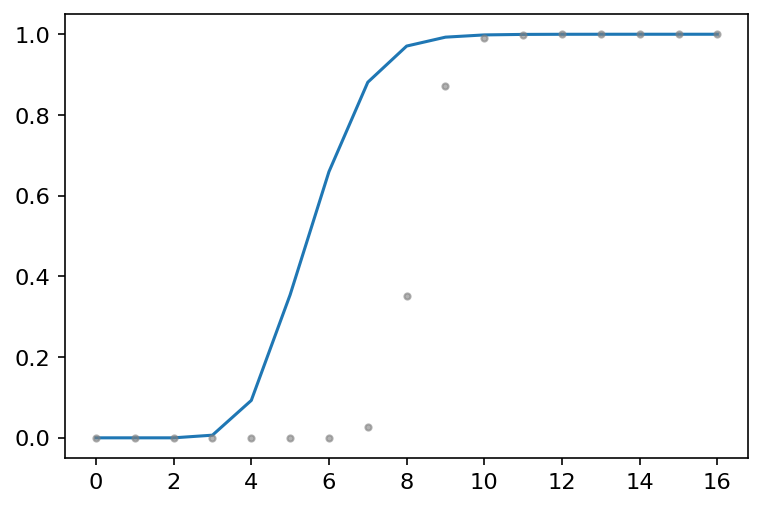

In [240]:
stats = cluster_data["10.0"]["avantgarde"]["clusters"][10]
cluster = stats.positive[0]

def n_pos(stats):
    return np.mean([c_.noise_count + c_.sizes.sum() for c_ in stats.positive])


def n_neg(stats):
    return np.mean([c_.noise_count + c_.sizes.sum() for c_ in stats.negative])


plt.plot([np.mean(connectivity_stats(stats_)) for stats_ in cluster_data["10.0"]["affinityGoal"]["clusters"]])
plt.plot([random_connectivity(100, int(n_pos(stats_)), 1) for stats_ in cluster_data["10.0"]["affinityGoal"]["clusters"]], 
        c="gray", alpha=0.6, linestyle="", marker=".")

Text(0.5, 0, '$y_i$')

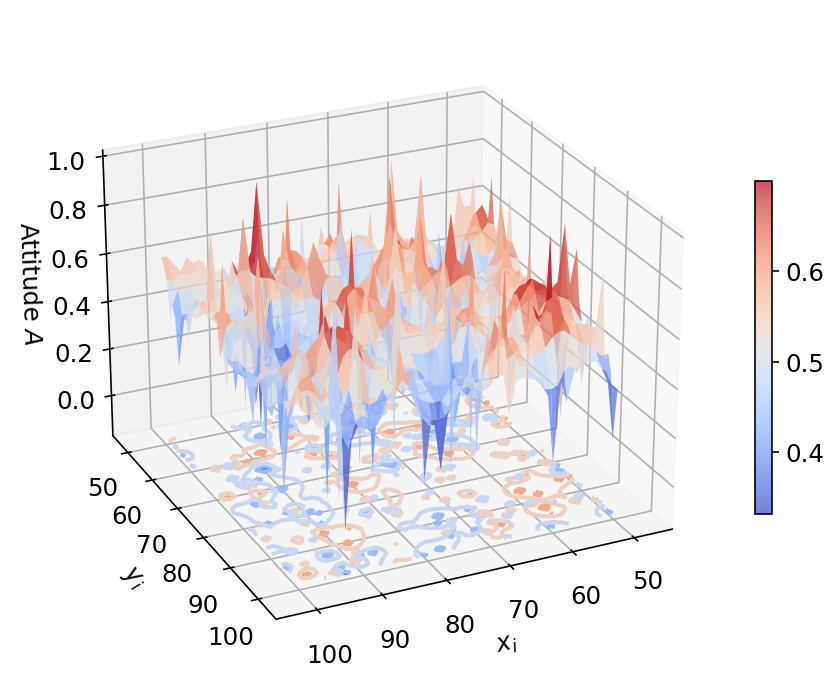

In [11]:
import matplotlib

file_uniform = "../data/distributions/agent_data_1000steps.csv"
data_uniform = LoadSimulation(file_uniform, columns=["step", "id", "affinity", "avantgarde", "affinityGoal", "seed"])

sample_uniform = data_uniform.query("seed == 100")

phi_m = np.linspace(50, 100, 50)
phi_p = np.linspace(50, 100, 50)
X,Y = np.meshgrid(phi_p, phi_m)
Z = Grid(Choice(sample_uniform, 1000))[50:, 50:]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')

offset = 5
cset=ax.plot_surface(X, Y, Z, rstride=2, cstride=2, alpha=0.7, cmap="coolwarm")
ax.contour(X, Y, Z, zdir='z', offset=-0.15, cmap="coolwarm", linewidths=2, linestyles='solid')

ax.set_xlim3d(-offset+50, 100 + offset)
ax.set_ylim3d(-offset+50, 100 + offset)
ax.set_zlim3d(-0.15, 1)
ax.set_proj_type('persp')
ax.view_init(elev=25, azim=65)
ax.grid(True)

plt.colorbar(cset, shrink=0.5)

ax.set_zlabel(r"Attitude $A$")
ax.set_xlabel(r"$x_i$")
ax.set_ylabel(r"$y_i$")


In [268]:
#############################
# self-reliance check
########################
from BlockNNClustering import *
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

from dataclasses import *
import numpy as np
import itertools
import os

columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
block_clustering = BlockNNClustering(min_cluster_size=1)

N = 100
modes = np.arange(0.1, 0.91, 0.05)                             
concentrations = (5.0, 10.0)

# init result dict
clusters = {c: [] for c in concentrations}
for concentration, mode in itertools.product(concentrations, modes):
    # select files
    location = "..\data\paramstest/uncorrelated"
    file = f"agent_data_beta-avantgarde_mode-{mode:.2f}_concentration-{concentration:.1f}.csv"
    
    print("Loading file " + file)
    
    path = os.path.join(location, file)
    data = LoadSimulation(path, columns=columns)

    # calculate properties
    scs = StateClusterStats.create()

    # get clusters
    for seed, df in data.query("step == 400").groupby("seed"):
        Aii = df.get("affinity").values
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)
        unique = np.unique(decisions)
        if unique.size == 1:
            is_pos = unique[0] == 1
            if is_pos: 
                pos = np.zeros(decisions.shape)
                neg = np.ones(decisions.shape) * (-2)
            else:
                pos = np.ones(decisions.shape) * (-2)
                neg = np.zeros(decisions.shape)

            _, all_labels = (None, (neg, pos))
        else:
            _, all_labels = block_clustering.fit(decisions)
        scs.add(StateClusters.build(all_labels), seed)

    # save
    clusters[concentration].append(scs)

Loading file agent_data_beta-avantgarde_mode-0.10_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.15_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.20_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.25_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.30_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.35_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.40_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.45_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.50_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.55_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.60_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.65_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.70_concentration-5.0.csv
Loading file agent_data_beta-avantgarde_mode-0.75_concentration-

In [269]:
#############################
# self-reliance check
########################
N = 100

# init result dict
clusters[999.999] = []
for mode in modes:
    # select files
    location = "..\data\paramstest"
    file = f"agent_data_constant-avantgarde_mode-{mode:.2f}.csv"
    
    print("Loading file " + file)
    
    path = os.path.join(location, file)
    data = LoadSimulation(path, columns=columns)

    # calculate properties
    scs = StateClusterStats.create()

    # get clusters
    for seed, df in data.query("step == 400").groupby("seed"):
        Aii = df.get("affinity").values
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)
        unique = np.unique(decisions)
        if unique.size == 1:
            is_pos = unique[0] == 1
            if is_pos: 
                pos = np.zeros(decisions.shape)
                neg = np.ones(decisions.shape) * (-2)
            else:
                pos = np.ones(decisions.shape) * (-2)
                neg = np.zeros(decisions.shape)

            _, all_labels = (None, (neg, pos))
        else:
            _, all_labels = block_clustering.fit(decisions)
        scs.add(StateClusters.build(all_labels), seed)

    # save
    clusters[999.999].append(scs) # constant key: 999.999 (infinity)

Loading file agent_data_constant-avantgarde_mode-0.10.csv
Loading file agent_data_constant-avantgarde_mode-0.15.csv
Loading file agent_data_constant-avantgarde_mode-0.20.csv
Loading file agent_data_constant-avantgarde_mode-0.25.csv
Loading file agent_data_constant-avantgarde_mode-0.30.csv
Loading file agent_data_constant-avantgarde_mode-0.35.csv
Loading file agent_data_constant-avantgarde_mode-0.40.csv
Loading file agent_data_constant-avantgarde_mode-0.45.csv
Loading file agent_data_constant-avantgarde_mode-0.50.csv
Loading file agent_data_constant-avantgarde_mode-0.55.csv
Loading file agent_data_constant-avantgarde_mode-0.60.csv
Loading file agent_data_constant-avantgarde_mode-0.65.csv
Loading file agent_data_constant-avantgarde_mode-0.70.csv
Loading file agent_data_constant-avantgarde_mode-0.75.csv
Loading file agent_data_constant-avantgarde_mode-0.80.csv
Loading file agent_data_constant-avantgarde_mode-0.85.csv
Loading file agent_data_constant-avantgarde_mode-0.90.csv


In [195]:
np.stack([np.array([0, 1]), np.array([2, 4])], axis=1)

array([[0, 2],
       [1, 4]])

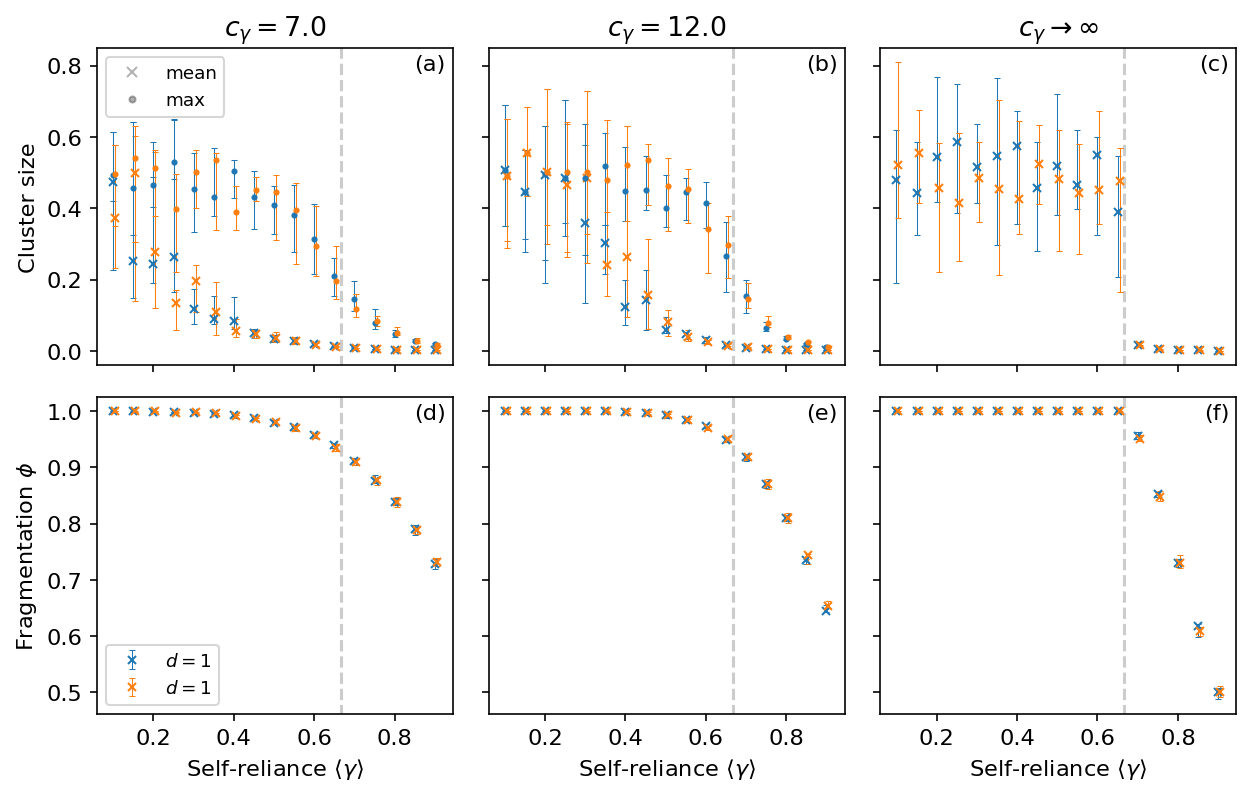

In [273]:
N = 10_000

def size_pos(stats, func=lambda x: x.mean()):
    return [func(c_.sizes)/N if c_.sizes.any() else 0 for c_ in stats.positive]

def size_neg(stats, func=lambda x: x.mean()):
    return [func(c_.sizes)/N if c_.sizes.any() else 0 for c_ in stats.negative]

plt.rcParams.update({"figure.dpi": 147, "font.size": 11})
fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharey="row", sharex="col")

kwargs = {"marker": "x", "ms": 4, "linestyle":"", "capsize": 1.5,"capthick":0.5, "elinewidth": 0.5}
kwargs_max = {**kwargs, "marker": "o", "ms":2}

cpos={"color": "tab:blue"}
cneg={"color": "tab:orange"}

gap = 0.005

key = 5.0
axis = ax[0, 0]

_data = [size_pos(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"mean | $d=1$", **kwargs, **cpos)

_data = [size_neg(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"mean | $d=0$", **kwargs, **cneg)

_data = [size_pos(x_, func=lambda x: x.max()) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"max | $d=1$", **kwargs_max, **cpos)

_data = [size_neg(x_, func=lambda x: x.max()) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"max | $d=0$", **kwargs_max, **cneg)

key = 10.0
axis = ax[0, 1]

_data = [size_pos(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"mean | $d=1$", **kwargs, **cpos)

_data = [size_neg(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"mean | $d=0$", **kwargs, **cneg)

_data = [size_pos(x_, func=lambda x: x.max()) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"max | $d=1$", **kwargs_max, **cpos)

_data = [size_neg(x_, func=lambda x: x.max()) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"max | $d=0$", **kwargs_max, **cneg)

key = 999.999
axis = ax[0, 2]

_data = [size_pos(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"mean | $d=1$", **kwargs, **cpos)

_data = [size_neg(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"mean | $d=0$", **kwargs, **cneg)

# _data = [size_pos(x_, func=lambda x: x.max()) for x_ in clusters[key]]
# axis.errorbar(modes, [np.mean(x) for x in _data], yerr=[np.std(x)/np.sqrt(len(x)) for x in _data], 
#               label=fr"max | $d=1$", **kwargs)

# _data = [size_neg(x_, func=lambda x: x.max()) for x_ in clusters[key]]
# axis.errorbar(modes+gap, [np.mean(x) for x in _data], yerr=[np.std(x)/np.sqrt(len(x)) for x in _data], 
#               label=fr"max | $d=0$", **kwargs)


key = 5.0
axis = ax[1, 0]

_data = [connectivity_stats(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"$d=1$", **kwargs)

_data = [connectivity_neg(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"$d=1$", **kwargs)

key = 10.0
axis = ax[1, 1]

_data = [connectivity_stats(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"$d=1$", **kwargs)

_data = [connectivity_neg(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"$d=0$", **kwargs)

key = 999.999
axis = ax[1, 2]

_data = [connectivity_stats(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes, y=medians, yerr=yerr, 
              label=fr"$d=1$", **kwargs)

_data = [connectivity_neg(x_) for x_ in clusters[key]]
medians = np.array([np.median(d) for d in _data])
q1 = np.array([np.percentile(d, 25) for d in _data])
q3 = np.array([np.percentile(d, 75) for d in _data])
yerr = np.array([medians - q1, q3 - medians])
axis.errorbar(modes+gap, y=medians, yerr=yerr, 
              label=fr"$d=1$", **kwargs)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(3):
    ax[1, i].set_xlabel(r"Self-reliance $\langle\gamma\rangle$")

ax[0,0].set_ylabel("Cluster size")
ax[1,0].set_ylabel(r"Fragmentation $\phi$")

ax[0,0].set_title(r"$c_{\gamma} = 7.0$")
ax[0,1].set_title(r"$c_{\gamma} = 12.0$")
ax[0,2].set_title(r"$c_{\gamma} \rightarrow\infty$")

for axis in ax.flatten():
    x = [2/3, 2/3]
    y = [-0.5, 1.5]
    lim = axis.get_ylim()
    axis.plot(x, y,color="black", alpha=0.2, linestyle="--")
    axis.set_ylim(lim)

for axis, number in zip(ax.flatten(), ("a", "b", "c", "d", "e", "f")):
    axis.text(x=0.98, y=0.98, ha='right', va='top', s=f"({number})", transform=axis.transAxes)
    
# create legends
marker_mean = plt.Line2D([], [], linestyle='none', marker='x', alpha=0.3, color='black', markersize=5)
marker_max = plt.Line2D([], [], linestyle='none', marker='o', alpha=0.3, color='black', markersize=3)

# add the legend to the plot
ax[0,0].legend(handles=[marker_mean, marker_max], labels=["mean", "max"], loc='upper left', fontsize=9)
ax[1,0].legend(fontsize=9)

Parameters: [-2.29657597  2.56601728]
Errors: [0.01565823 0.01203297]
Chi-squared: 4.7005606884885465


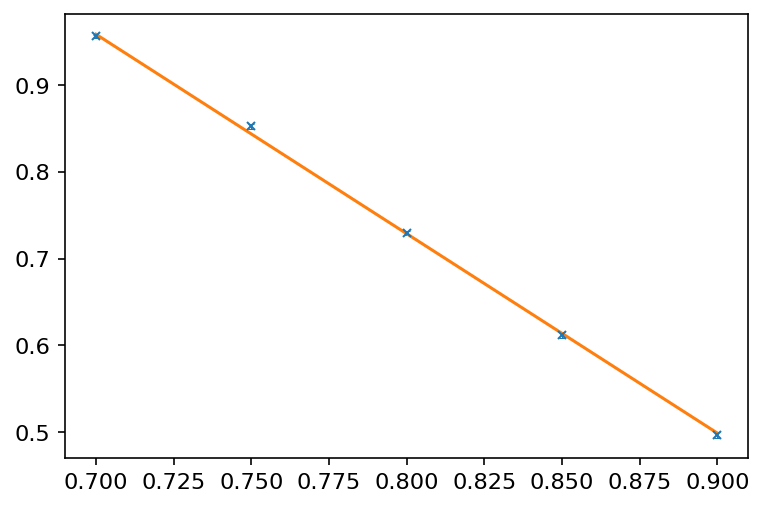

In [303]:
import numpy as np
from scipy.optimize import curve_fit

# data
key = 999.999
start = 12
_data = [connectivity_stats(x_) for x_ in clusters[key]]
medians = np.array([np.mean(d) for d in _data])
yerr = np.array([np.std(d) / np.sqrt(len(d)) for d in _data])[start:]

x_data = modes[start:]
y_data = means[start:]

# Define a linear function
def linear_function(x, a, b):
    return a * x + b

# Generate example data
x_data = modes[start:]
y_data = medians[start:]

# Fit the data to the linear function
popt, pcov = curve_fit(linear_function, x_data, y_data, sigma=yerr, absolute_sigma=True)

# Calculate the errors (standard deviation) of the fit parameters
perr = np.sqrt(np.diag(pcov))

# Calculate the fitted y values
y_fit = linear_function(x_data, *popt)

# Calculate the residuals
residuals = y_data - y_fit

dof = x_data.size - 2

# Calculate the chi-squared value
chi_squared = np.sum((residuals ** 2) / yerr**2)

# Print the results
print("Parameters:", popt)
print("Errors:", perr)
print("Chi-squared:", chi_squared / dof)

fig, axis = plt.subplots()

axis.errorbar(x_data, y=y_data, yerr=yerr, 
              label=fr"$d=1$", **kwargs)

axis.plot(x_data, linear_function(x_data, *popt))

In [308]:
y_uni = uni_fragmentation[0]
x_uni_equiv = (y_uni - popt[1]) / popt[0]

def propagated_error(y, a, b, sigma_y, sigma_a, sigma_b):
    """
    Calculates the propagated error for the function (y-b)/a.
    
    Parameters:
        y (float): Value of y.
        a (float): Value of a.
        b (float): Value of b.
        sigma_y (float): Uncertainty in y.
        sigma_a (float): Uncertainty in a.
        sigma_b (float): Uncertainty in b.
        
    Returns:
        float: Propagated error for the function (y-b)/a.
    """
    # Partial derivatives
    df_dy = 1 / a
    df_da = -(y - b) / a**2
    df_db = -1 / a
    
    # Propagated error
    sigma = np.sqrt((df_dy * sigma_y)**2 + (df_da * sigma_a)**2 + (df_db * sigma_b)**2)
    
    return sigma

x_uni_equiv_err = propagated_error(y_uni, popt[0], popt[1], uni_fragmentation[1], perr[0], perr[1])
print(x_uni_equiv, x_uni_equiv_err)

0.7161525975183138 0.00807438168233861


In [380]:
uni_fragmentation

(0.9213184373190999, 0.008562697674523632)

In [104]:
# select files
location = "..\data\paramstest"
file = f"agent_data_constant-avantgarde_mode-{0.8:.2f}.csv"

print("Loading file " + file)

path = os.path.join(location, file)
data = LoadSimulation(path, columns=columns)

Loading file agent_data_constant-avantgarde_mode-0.80.csv


In [469]:
#mapping2[~]
np.isin(mapping2, mapping, axis=1)

TypeError: isin() got an unexpected keyword argument 'axis'

In [501]:
import numpy as np

# Example arrays
array1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
array2 = np.array([[2, 3, 4], [5, 6, 7], [9, 10, 7]])

# Broadcasting and reshaping arrays
array1_reshaped = array1[:, :, None]
array2_reshaped = array2[:, None, :]

b = np.array((array1_reshaped == array2_reshaped).sum(axis=2), dtype=bool)

array1[b]

array([2, 3, 5, 6, 7, 9])

In [507]:
mapping2 = np.array([[u for u in x if u not in y] for x,y in zip(mapping2, mapping)])
mapping2.shape

(10000, 16)

In [520]:
def decay_friends(df):
    avg_friends = 0
    for r in np.arange(1,5):
        counts = np.array(friends_count(sample, mappings[r-1]))
        counts = counts / ((2*r+1)**2 - (2*r-1)**2)
        avg_friends += scale * np.exp(-r) * np.mean(counts)

decay_friends(sample)

In [2]:
import metrics
reload(metrics)
from metrics import *

mapping = create_index_mapping(100)
mapping2 = create_index_mapping(100, r=2)
mapping3 = create_index_mapping(100, r=3)
mapping4 = create_index_mapping(100, r=4)

mapping_filtered_2 = np.array([[u for u in x if u not in y] for x,y in zip(mapping2, mapping)])
mapping_filtered_3 = np.array([[u for u in x if u not in y] for x,y in zip(mapping3, mapping2)])
mapping_filtered_4 = np.array([[u for u in x if u not in y] for x,y in zip(mapping4, mapping3)])

scale = 1./np.sum(np.exp(-np.arange(1,5)))

mappings = (mapping, mapping_filtered_2, mapping_filtered_3, mapping_filtered_4)

def decay_friends(df):
    avg_friends = np.zeros(df.get("avantgarde").values.size)
    for r in np.arange(1,5):
        counts = np.array(friends_count(sample, mappings[r-1]))
        counts = counts / ((2*r+1)**2 - (2*r-1)**2)
        avg_friends += scale * np.exp(-r) * counts
    return avg_friends

In [214]:
import metrics
reload(metrics)
from metrics import *

N = 100

# select files
location = "..\data\paramstest"
files = []
fkey = "avantgarde"
num = "5.0"
for fname in os.listdir(location):
    if f"-{num}" in fname and f"-{fkey}" in fname \
        and "_mode" in fname:
        files.append(os.path.join(location, fname))

mapping = create_index_mapping(100)

# load data
def process_file(file):
    # Log
    print(f"Working on: {file}")
    data = LoadSimulation(file, columns=["seed", "id", "avantgarde", "affinity", "affinityGoal", "step"])
    mode = float(file.split("mode-")[1].split("_")[0].split(".csv")[0])
    eq_data = data.query("step == 100")
    mean = eq_data.get("avantgarde").mean()
    
    metrics = []
    # get metrics
    for s, sample in eq_data.groupby("seed"): #.query("seed == @seed")
        Aii = sample.get("affinity").values
        doi = density_of_interfaces(np.int32(Aii >= 0.5), mapping)
    
        friends_result = np.array(friends_count(sample, mapping)) / 8
        friends_mean = np.mean(friends_result)
        friends_q5 = np.percentile(friends_result, 5)
        friends_q25 = np.percentile(friends_result, 25)
        friends_q50 = np.percentile(friends_result, 50)
        friends_q75 = np.percentile(friends_result, 75)
        friends_q95 = np.percentile(friends_result, 95)
        
        decision_result = decision_alignment(sample)
        decision_mean = np.mean(decision_result)
        
        satisfaction_result = satisfaction(sample, mapping)
        satisfaction_mean = np.mean(satisfaction_result)
        #satisfaction_std = np.std(satisfaction_result)
        satisfaction_q5 = np.percentile(satisfaction_result, 25)
        satisfaction_q95 = np.percentile(satisfaction_result, 75)
        
        metrics.append((doi, friends_mean, decision_mean, 
                        friends_q5, friends_q25, friends_q50, friends_q75, friends_q95,
                        satisfaction_mean, satisfaction_q5, satisfaction_q95))

    return mean, list(zip(*metrics))

x, y = zip(*[process_file(file) for file in files])

Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.10_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.15_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.20_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.25_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.30_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.35_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.40_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.45_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.50_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.55_concentration-5.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.60_concentration-5.0.csv
Working on

In [167]:
files = []
num = "10.0"
for fname in os.listdir(location):
    if f"-{num}" in fname and f"-{fkey}" in fname \
        and "_mode" in fname:
        files.append(os.path.join(location, fname))
        
x10, y10 = zip(*[process_file(file) for file in files])

Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.10_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.15_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.20_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.25_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.30_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.35_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.40_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.45_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.50_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.55_concentration-10.0.csv
Working on: ..\data\paramstest\agent_data_beta-avantgarde_mode-0.60_concentration-10.0.csv

In [215]:
files = []
num = "constant"
for fname in os.listdir(location):
    if f"_{num}" in fname and f"-{fkey}" in fname \
        and "_mode" in fname:
        files.append(os.path.join(location, fname))
        
xc, yc = zip(*[process_file(file) for file in files])

Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.00.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.05.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.10.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.15.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.20.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.25.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.30.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.35.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.40.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.45.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.50.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.55.csv
Working on: ..\data\paramstest\agent_data_constant-avantgarde_mode-0.60.csv
Working on: 

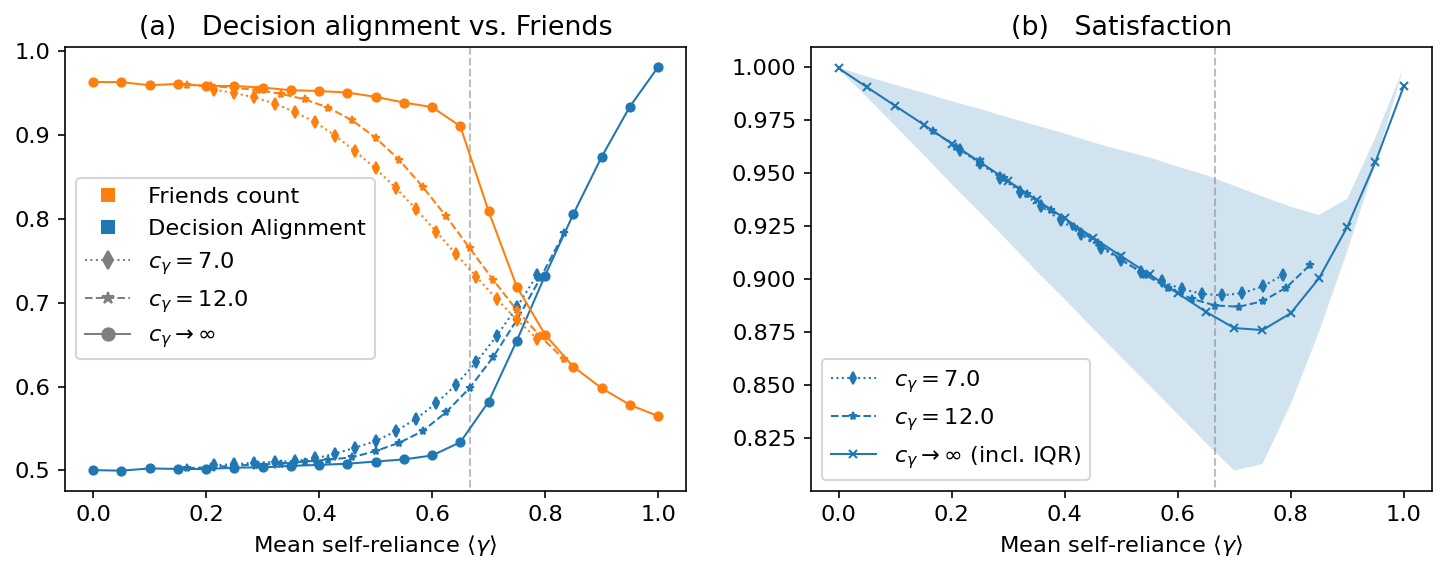

In [231]:
plt.rcParams.update({"font.size":11, "figure.dpi": 147, "lines.linewidth": 1.0})
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))

yy = np.array(y)
yy10 = np.array(y10)
yyc = np.array(yc)

ax.errorbar(x, yy[:,2].mean(axis=1), label="Decision alignment 1", 
            marker="d", linestyle=":", color="tab:blue", markersize=4)

ax.errorbar(x10, yy10[:,2].mean(axis=1), label="Decision alignment3", 
            marker="*", linestyle="--", color="tab:blue", markersize=4)

ax.errorbar(xc, yyc[:,2].mean(axis=1), label="Decision alignment 2", 
            marker="o", linestyle="-", color="tab:blue", markersize=4)

ax.errorbar(x, yy[:,1].mean(axis=1), label="N.N. Friends", marker="d", linestyle=":", color="tab:orange", markersize=4)
ax.errorbar(x10, yy10[:,1].mean(axis=1), label="N.N. Friends", marker="*", linestyle="--", color="tab:orange", markersize=4)
ax.errorbar(xc, yyc[:,1].mean(axis=1), label="N.N. Friends", marker="o", linestyle="-", color="tab:orange", markersize=4)

ax.set_xlabel(r"Mean self-reliance $\langle \gamma \rangle$")
ax1.set_xlabel(r"Mean self-reliance $\langle \gamma \rangle$")

ax1.errorbar(x, yy[:,8].mean(axis=1), label=r'$c_{\gamma} = 7.0$', 
            marker="d", linestyle=":", color="tab:blue", markersize=4)

ax1.errorbar(x10, yy10[:,8].mean(axis=1), label=r'$c_{\gamma} = 12.0$', 
            marker="*", linestyle="--", color="tab:blue", markersize=4)

ax1.errorbar(xc, yyc[:,8].mean(axis=1), label=r'$c_{\gamma} \rightarrow \infty$ (incl. IQR)', 
            marker="x", linestyle="-", color="tab:blue", markersize=4)

ax1.fill_between(xc, yyc[:,9].mean(axis=1), yyc[:,10].mean(axis=1), alpha=0.2)

#ax.set_ylabel(r"$y\left(t_{equil.}\right) - y(t_{initial})$")

from matplotlib.lines import Line2D
# Create custom legend handles and labels
legend_handles = [
    Line2D([0], [0], marker='s', color='tab:orange', linestyle="", markersize=6, label='Friends count'),
    Line2D([0], [0], marker='s', color='tab:blue', linestyle="", markersize=6, label='Decision Alignment'),
    Line2D([0], [0], color='tab:gray', linestyle=':', marker="d", linewidth=1, label=r'$c_{\gamma} = 7.0$'),
    Line2D([0], [0], color='tab:gray', linestyle='--', marker='*', linewidth=1, label=r'$c_{\gamma} = 12.0$'),
    Line2D([0], [0], color='tab:gray', linestyle='-', marker='o', linewidth=1, label=r'$c_{\gamma} \rightarrow \infty$')
]

# Add the legend to the plot
ax.legend(handles=legend_handles, loc='best')

ax1.legend(fontsize=11)

ax.set_ylim(ax.get_ylim())
ax1.set_ylim(ax1.get_ylim())
ax.plot([2/3, 2/3], [0, 1.1], color="tab:gray",linestyle="--", alpha=0.5)
ax1.plot([2/3, 2/3], [0, 1.1], color="tab:gray",linestyle="--", alpha=0.5)

ax.set_title(r"(a)   Decision alignment vs. Friends")
ax1.set_title(r"(b)   Satisfaction")
plt.show()

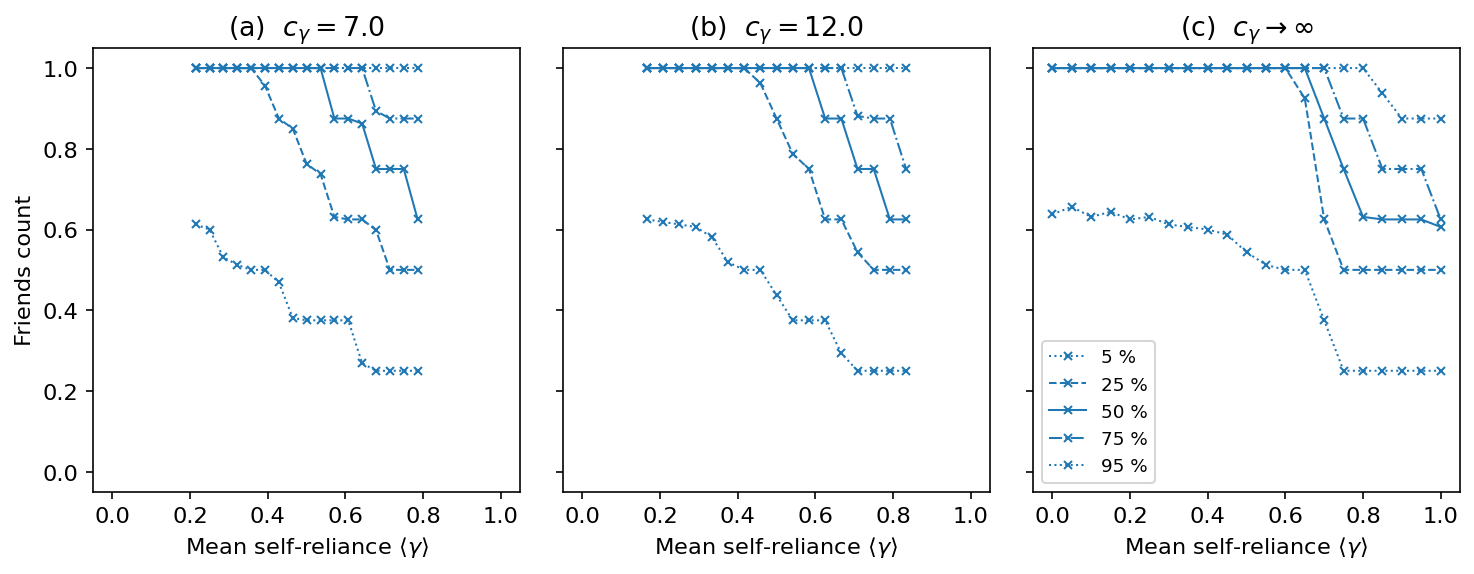

In [227]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].set_ylabel("Friends count")

for axis, x_, y_ in zip(axes, (x, x10, xc), (yy, yy10, yyc)):
    axis.plot(x_, y_[:,3].mean(axis=1), label="5 %", linestyle=":", marker="x", ms="4", color="tab:blue")
    axis.plot(x_, y_[:,4].mean(axis=1), label="25 %", linestyle="--",marker="x", ms="4", color="tab:blue")
    axis.plot(x_, y_[:,5].mean(axis=1), label="50 %", linestyle="-", marker="x", ms="4",color="tab:blue")
    axis.plot(x_, y_[:,6].mean(axis=1), label="75 %", linestyle="-.", marker="x", ms="4",color="tab:blue")
    axis.plot(x_, y_[:,7].mean(axis=1), label="95 %", linestyle=":", marker="x", ms="4", color="tab:blue")

    axis.set_xlabel(r"Mean self-reliance $\langle \gamma \rangle$")
    axis.set_ylim([-0.05,1.05])
    axis.set_xlim([-0.05,1.05])

axes[0].set_title(r"(a)  $c_{\gamma} = 7.0$")
axes[1].set_title(r"(b)  $c_{\gamma} = 12.0$")
axes[2].set_title(r"(c)  $c_{\gamma} \rightarrow \infty$")
    
axes[2].legend(fontsize=9)
plt.subplots_adjust(wspace=0.1)


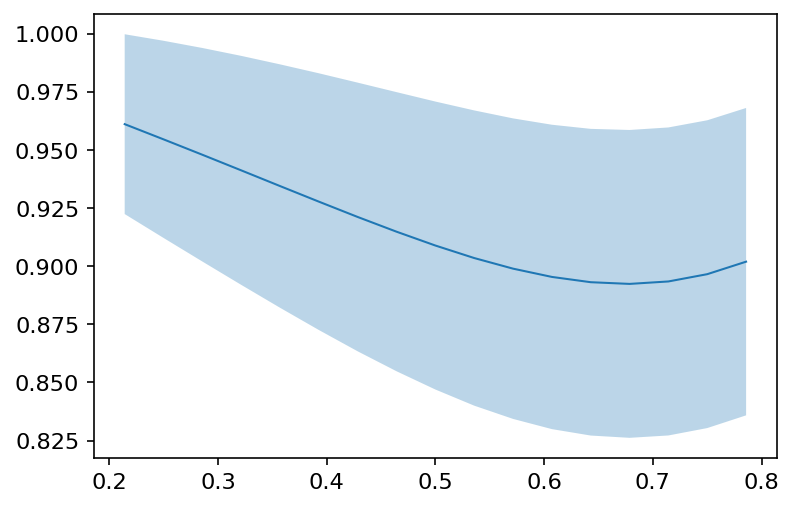

In [166]:
yy = np.array(y)

ax = plt.plot(x, yy[:,8].mean(axis=1))
plt.fill_between(x, yy[:,8].mean(axis=1)-yy[:,9].mean(axis=1), yy[:,8].mean(axis=1)+yy[:,9].mean(axis=1), alpha=0.3)

In [90]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

In [45]:
#################
# helpers
def index_to_crds(index, Nx):
    coords = np.zeros(2, dtype='int32')
    coords[1] = int(index % Nx)
    coords[0] = int(index / Nx)
    return coords

def crds_to_index(coords, Nx):
    return int(coords[0] * Nx + coords[1])

def get_neighbour_crds(i, j, Nx, Ny, r=1):
    """
    Returns the list of neighboring indices for a cell at position (i, j)
    in a 2D grid with periodic boundary conditions and dimensions Nx x Ny.
    """
    di_values = list(range(-r, r+1))
    dj_values = list(range(-r, r+1))
    neighbours = [((i+di) % Nx, (j+dj) % Ny)
                 for di in di_values
                 for dj in dj_values
                 if di != 0 or dj != 0]
    return neighbours

def map_index_to_neighbours(idx, N, r=1):
    return [crds_to_index(crd, N) for crd in get_neighbour_crds(*index_to_crds(idx, N), N, N, r=r)]
    

index_mapping = np.array([map_index_to_neighbours(k, 100) for k in range(10_000)])
index_to_ids_mapping = index_mapping + 1

def map_ids(ids):
    # to index
    indices = ids - 1
    mapped = index_to_ids_mapping[indices]
    return mapped


def density_of_interfaces(array):
    return np.logical_xor(array[index_mapping] >= 0.5, np.tile(array >= 0.5, (8,1)).transpose()).sum() / (8 * array.size)
    

def magnetisation(array):
    return (np.sum(array >= 0.5) - np.sum(array < 0.5)) / array.size

In [128]:
from BlockNNClustering import *
from dataclasses import dataclass

@dataclass
class AnalyzedModelState:
    magnetisation: float
    density_of_interfaces: float
    mean_size: tuple
    cluster_count: tuple
    fragmentation: tuple
    
    @staticmethod
    def build(decision_grid):
        my_clustering = BlockNNClustering(min_cluster_size=1)
        _, labels = my_clustering.fit(decision_grid)
        
        if len(labels) == 2:
            (neg, pos) = labels
        else:
            if np.unique(decision_grid)[0] == 0:
                (neg, pos) = (decision_grid+1, (decision_grid+1)*(-2))
            else:
                (neg, pos) = (decision_grid*(-2), decision_grid)
        
        flattened = decision_grid.flatten()
        return AnalyzedModelState(
            magnetisation(flattened),
            density_of_interfaces(flattened),
            (mean_size_from_labels(neg), mean_size_from_labels(pos)),
            (cluster_count_from_labels(neg), cluster_count_from_labels(pos)),
            (connectivity_from_labels(neg), connectivity_from_labels(pos)),
        )

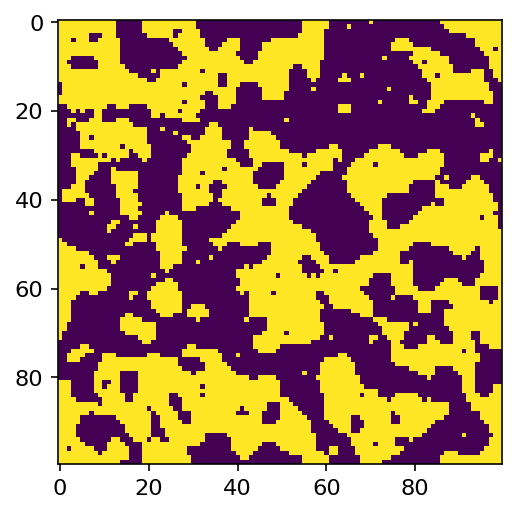

In [311]:
### Transitions
##################
location = "../data/transitions"
file = "agent_data_avantgarde_m-0.685.csv"
path = os.path.join(location, file)
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(path, columns=columns)

sample = data.query("seed == 113")
plt.imshow(sample.get("affinity").values.reshape(100, 100) >= 0.5)

In [365]:
mm = np.arange(0.6, 0.701, 0.002)
seeds = np.arange(100, 149, 1)
results = []
for m in mm:
    file = f"agent_data_avantgarde_m-{m:.3f}.csv"
    print(file)
    path = os.path.join(location, file)
    data = LoadSimulation(path, columns=columns)

    stats = []
    for seed in seeds:
        sample = data.query("seed == @seed")
        decision_grid = np.array(sample.get("affinity").values.reshape(100, 100) >= 0.5, dtype="int")
        stats.append(AnalyzedModelState.build(decision_grid))
    
    results.append(stats)

agent_data_avantgarde_m-0.600.csv
agent_data_avantgarde_m-0.602.csv
agent_data_avantgarde_m-0.604.csv
agent_data_avantgarde_m-0.606.csv
agent_data_avantgarde_m-0.608.csv
agent_data_avantgarde_m-0.610.csv
agent_data_avantgarde_m-0.612.csv
agent_data_avantgarde_m-0.614.csv
agent_data_avantgarde_m-0.616.csv
agent_data_avantgarde_m-0.618.csv
agent_data_avantgarde_m-0.620.csv
agent_data_avantgarde_m-0.622.csv
agent_data_avantgarde_m-0.624.csv
agent_data_avantgarde_m-0.626.csv
agent_data_avantgarde_m-0.628.csv
agent_data_avantgarde_m-0.630.csv
agent_data_avantgarde_m-0.632.csv
agent_data_avantgarde_m-0.634.csv
agent_data_avantgarde_m-0.636.csv
agent_data_avantgarde_m-0.638.csv
agent_data_avantgarde_m-0.640.csv
agent_data_avantgarde_m-0.642.csv
agent_data_avantgarde_m-0.644.csv
agent_data_avantgarde_m-0.646.csv
agent_data_avantgarde_m-0.648.csv
agent_data_avantgarde_m-0.650.csv
agent_data_avantgarde_m-0.652.csv
agent_data_avantgarde_m-0.654.csv
agent_data_avantgarde_m-0.656.csv
agent_data_ava

<ErrorbarContainer object of 3 artists>

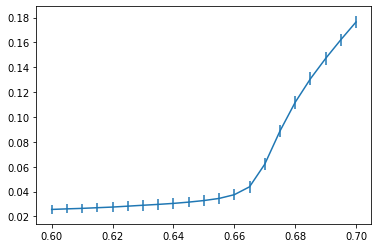

In [65]:
# plot magnetization
magn = [np.mean([s.density_of_interfaces for s in x]) for x in results]
magn_std = [np.std([s.density_of_interfaces for s in x]) for x in results]
plt.errorbar(mm, magn, yerr=magn_std)

<ErrorbarContainer object of 3 artists>

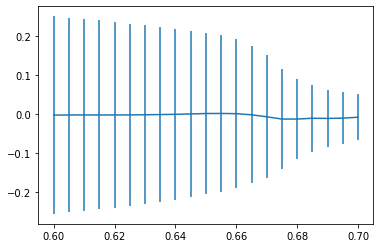

In [66]:
magn = [np.mean([s.magnetisation for s in x]) for x in results]
magn_std = [np.std([s.magnetisation for s in x]) for x in results]
plt.errorbar(mm, magn, yerr=magn_std)

<ErrorbarContainer object of 3 artists>

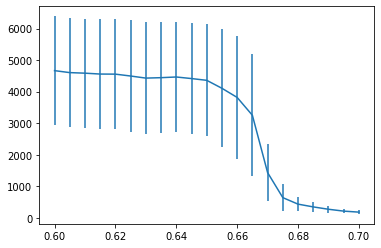

In [69]:
magn = [np.mean([s.mean_size for s in x]) for x in results]
magn_std = [np.std([s.mean_size for s in x]) for x in results]
plt.errorbar(mm, magn, yerr=magn_std)

<ErrorbarContainer object of 3 artists>

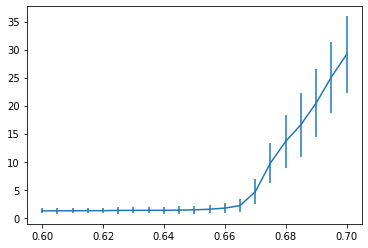

In [71]:
magn = [np.mean([s.cluster_count for s in x]) for x in results]
magn_std = [np.std([s.cluster_count for s in x]) for x in results]
plt.errorbar(mm, magn, yerr=magn_std)

<ErrorbarContainer object of 3 artists>

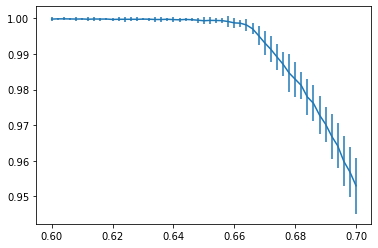

In [75]:
magn = [np.mean([s.fragmentation for s in x]) for x in results]
magn_std = [np.std([s.fragmentation for s in x]) for x in results]
plt.errorbar(mm, magn, yerr=magn_std)

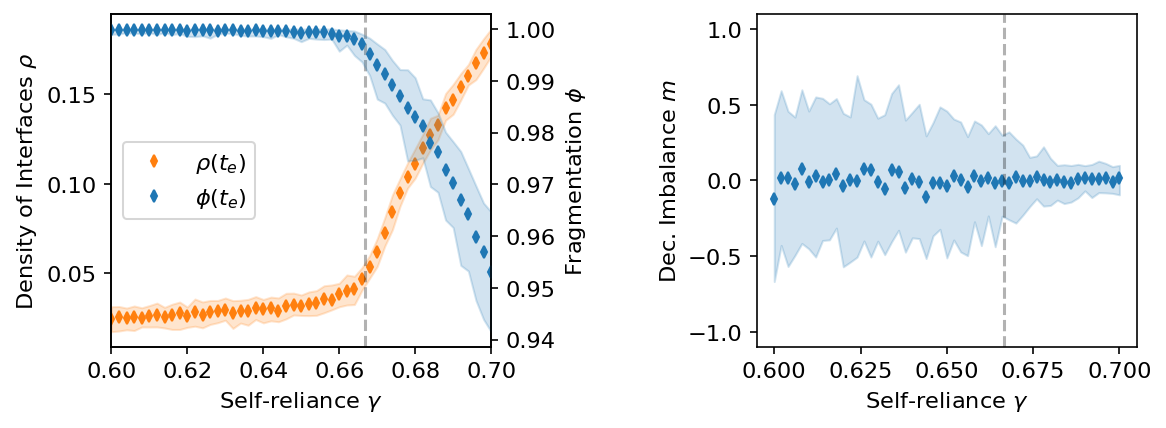

In [376]:
plt.rcParams.update({"figure.dpi": 147, "font.size": 11})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.))

# fragmentation
fmean = [np.mean([s.density_of_interfaces for s in x]) for x in results]
fmin = [np.percentile([s.density_of_interfaces for s in x], 5) for x in results]
fmax = [np.percentile([s.density_of_interfaces for s in x], 95) for x in results]
line1, = ax1.plot(mm, fmean, marker="d", linestyle="", ms="4", label=r"$\rho(t_e)$", color="tab:orange")
ax1.fill_between(mm, fmin, fmax, color="tab:orange", alpha=0.2)

ax1.set_ylim(ax1.get_ylim())
ax1.plot([2/3, 2/3], [0., 1.1], linestyle="--", color="black", alpha=0.3)

# density_of_interfaces
fmean = [np.mean([s.fragmentation for s in x]) for x in results]
fmin = [np.percentile([s.fragmentation for s in x], 5) for x in results]
fmax = [np.percentile([s.fragmentation for s in x], 95) for x in results]

ax1b = ax1.twinx()
line2, = ax1b.plot(mm, fmean, marker="d", linestyle="", ms="4", color="tab:blue", label=r"$\phi(t_e)$")
ax1b.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.2)
ax1.set_xlim([0.6, 0.7])
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center left")


# magnetization
fmean = [np.mean([s.magnetisation for s in x]) for x in results]
fmin = [np.percentile([s.magnetisation for s in x], 5) for x in results]
fmax = [np.percentile([s.magnetisation for s in x], 95) for x in results]
ax2.plot(mm, fmean, marker="d", linestyle="", ms="4", label=r"$\phi$")
ax2.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.2)
ax2.set_ylim([-1.1,1.1])
ax2.plot([2/3, 2/3], [-1.1, 1.1], linestyle="--", color="black", alpha=0.3)

ax1.set_xlabel(r"Self-reliance $\gamma$")
ax1b.set_ylabel(r"Fragmentation $\phi$")
ax1.set_ylabel(r"Density of Interfaces $\rho$")

ax2.set_xlabel(r"Self-reliance $\gamma$")
ax2.set_ylabel(r"Dec. Imbalance $m$")


plt.subplots_adjust(wspace=0.7)

In [184]:
file_uniform = "../data/distributions/agent_data_1000steps.csv"
data_uniform = LoadSimulation(file_uniform, columns=["step", "id", "affinity", "avantgarde", "affinityGoal", "seed"])

uni_ams = []
for seed in seeds:
    sample = data_uniform.query("step==1000").query("seed == @seed")
    decision_grid = np.array(sample.get("affinity").values.reshape(100, 100) >= 0.5, dtype="int")
    uni_ams.append(AnalyzedModelState.build(decision_grid))

In [188]:
np.mean([x.fragmentation for x in uni_ams])

0.9213184373190999

In [190]:
np.mean([x.density_of_interfaces for x in uni_ams])

0.22013673469387754

In [379]:
mm = np.arange(0.460, 0.540, 0.002)
seeds = np.arange(100, 149, 1)
resultsf = []
for m in mm:
    file = f"agent_data_goal_m-{m:.3f}.csv"
    print(file)
    path = os.path.join(location, file)
    data = LoadSimulation(path, columns=columns)

    stats = []
    for seed in seeds:
        sample = data.query("seed == @seed")
        decision_grid = np.array(sample.get("affinity").values.reshape(100, 100) >= 0.5, dtype="int")
        stats.append(AnalyzedModelState.build(decision_grid))
    
    resultsf.append(stats)

agent_data_goal_m-0.460.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.462.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.464.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.466.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.468.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.470.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.472.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.474.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.476.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.478.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.480.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.482.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.484.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.486.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.488.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.490.csv
agent_data_goal_m-0.492.csv
agent_data_goal_m-0.494.csv
agent_data_goal_m-0.496.csv
agent_data_goal_m-0.498.csv
agent_data_goal_m-0.500.csv
agent_data_goal_m-0.502.csv
agent_data_goal_m-0.504.csv
agent_data_goal_m-0.506.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.508.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.510.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.512.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.514.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.516.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.518.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.520.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.522.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.524.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.526.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.528.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.530.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.532.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.534.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.536.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.538.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


agent_data_goal_m-0.540.csv


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_20244/2820512496.py:7: RuntimeWarning: Mean of empty slice.
  return counts_[unique_labels_ >= 0].mean()
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [344]:
def percentile(array, p):
    if array: return np.percentile(array, p)
    return np.nan

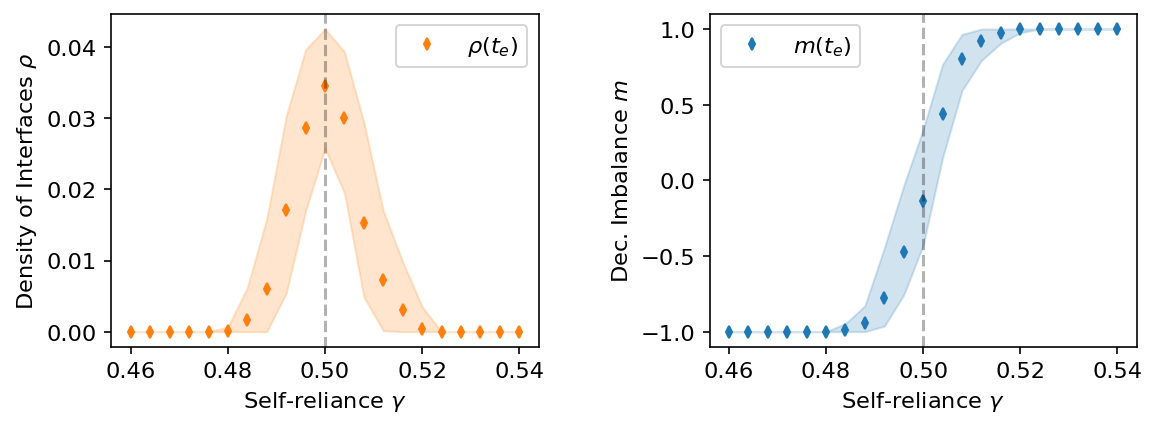

In [364]:
plt.rcParams.update({"figure.dpi": 147, "font.size": 11})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.))

# fragmentation
# fmean = [np.mean([s.fragmentation[0] for s in x if s.fragmentation[0] >= 0]) for x in results]
# fmin = [percentile([s.fragmentation[0] for s in x if s.fragmentation[0] >= 0], 5) for x in results]
# fmax = [percentile([s.fragmentation[0] for s in x if s.fragmentation[0] >= 0], 95) for x in results]
# line1, = ax1.plot(mm, fmean, marker="o", linestyle="", ms="4", label=r"$\phi(t_e)\ d=1$", color="tab:blue")
# ax1.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.2)

# fmean = [np.mean([s.fragmentation[1] for s in x if s.fragmentation[1] >= 0]) for x in results]
# fmin = [percentile([s.fragmentation[1] for s in x if s.fragmentation[1] >= 0], 5) for x in results]
# fmax = [percentile([s.fragmentation[1] for s in x if s.fragmentation[1] >= 0], 95) for x in results]
# line1b, = ax1.plot(mm, fmean, marker="d", linestyle="", ms="4", label=r"$\phi(t_e)\ d=1$", color="tab:blue", alpha=0.8)
# ax1.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.1)

# density_of_interfaces

fmean = [np.mean([s.density_of_interfaces for s in x]) for x in results]
fmin = [np.percentile([s.density_of_interfaces for s in x], 5) for x in results]
fmax = [np.percentile([s.density_of_interfaces for s in x], 95) for x in results]
ax1b = ax1#.twinx()
line2, = ax1b.plot(mm, fmean, marker="d", linestyle="", ms="4", color="tab:orange", label=r"$\rho(t_e)$")
ax1b.fill_between(mm, fmin, fmax, color="tab:orange", alpha=0.2)
#ax1.set_xlim([0.6, 0.7])
lines = [line1, line1b, line2]
labels = [l.get_label() for l in lines]
ax1b.legend() # lines, labels, loc="center left")

ax1.set_ylim(ax1.get_ylim())
ax1.plot([1/2, 1/2], [-0.1, 1.1], linestyle="--", color="black", alpha=0.3)

# magnetization
fmean = [np.mean([s.magnetisation for s in x]) for x in results]
fmin = [np.percentile([s.magnetisation for s in x], 5) for x in results]
fmax = [np.percentile([s.magnetisation for s in x], 95) for x in results]
ax2.plot(mm, fmean, marker="d", linestyle="", ms="4", label=r"$m(t_e)$")
ax2.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.2)
ax2.set_ylim([-1.1,1.1])
ax2.plot([1/2, 1/2], [-1.1, 1.1], linestyle="--", color="black", alpha=0.3)
ax2.legend()

ax1.set_xlabel(r"Self-reliance $\gamma$")
ax1.set_ylabel(r"Fragmentation $\phi$")
ax1b.set_ylabel(r"Density of Interfaces $\rho$")

ax2.set_xlabel(r"Self-reliance $\gamma$")
ax2.set_ylabel(r"Dec. Imbalance $m$")


plt.subplots_adjust(wspace=0.4)

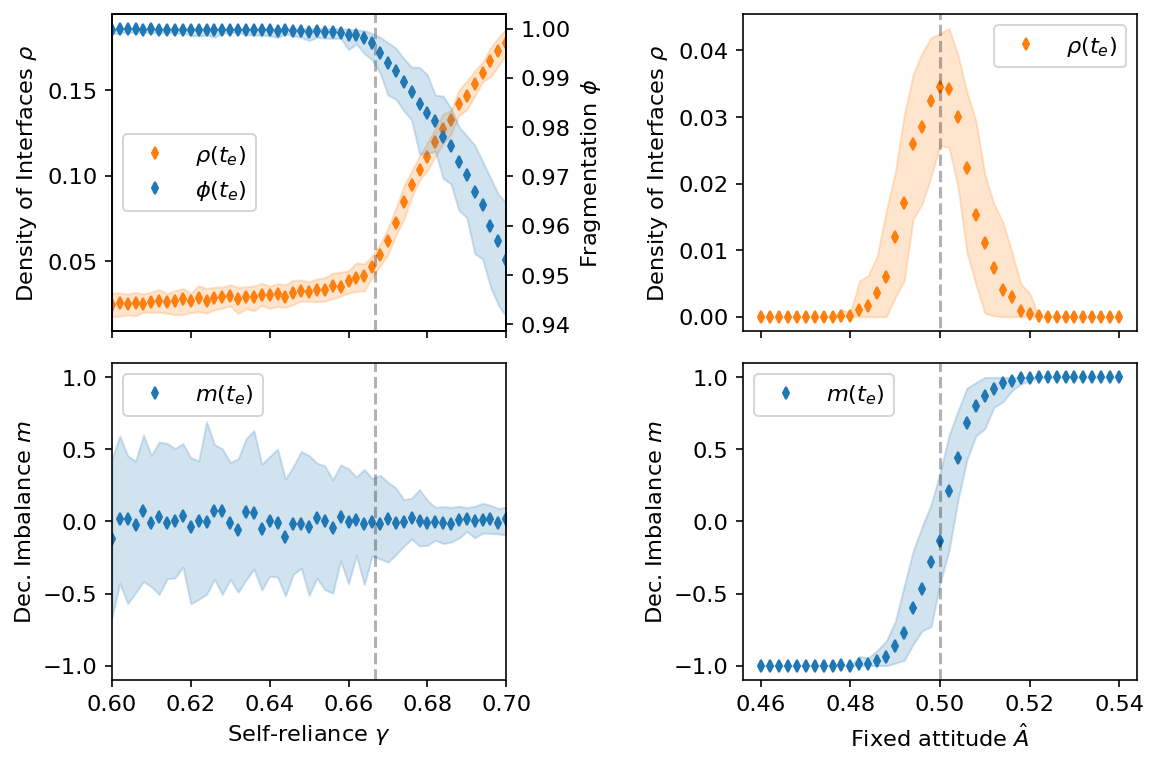

In [407]:
plt.rcParams.update({"figure.dpi": 147, "font.size": 11})
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(9, 6), sharex="col")


mm = np.arange(0.6, 0.701, 0.002)
# fragmentation
fmean = [np.mean([s.density_of_interfaces for s in x]) for x in results]
fmin = [np.percentile([s.density_of_interfaces for s in x], 5) for x in results]
fmax = [np.percentile([s.density_of_interfaces for s in x], 95) for x in results]
line1, = ax1.plot(mm, fmean, marker="d", linestyle="", ms="4", label=r"$\rho(t_e)$", color="tab:orange")
ax1.fill_between(mm, fmin, fmax, color="tab:orange", alpha=0.2)

ax1.set_ylim(ax1.get_ylim())
ax1.plot([2/3, 2/3], [0., 1.1], linestyle="--", color="black", alpha=0.3)

# density_of_interfaces
fmean = [np.mean([s.fragmentation for s in x]) for x in results]
fmin = [np.percentile([s.fragmentation for s in x], 5) for x in results]
fmax = [np.percentile([s.fragmentation for s in x], 95) for x in results]

ax1b = ax1.twinx()
line2, = ax1b.plot(mm, fmean, marker="d", linestyle="", ms="4", color="tab:blue", label=r"$\phi(t_e)$")
ax1b.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.2)
ax1.set_xlim([0.6, 0.7])
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="center left")

mmf = np.arange(0.460, 0.540, 0.002)
# magnetization
fmean = [np.mean([s.magnetisation for s in x]) for x in results]
fmin = [np.percentile([s.magnetisation for s in x], 5) for x in results]
fmax = [np.percentile([s.magnetisation for s in x], 95) for x in results]
ax2.plot(mm, fmean, marker="d", linestyle="", ms="4", label=r"$m(t_e)$")
ax2.fill_between(mm, fmin, fmax, color="tab:blue", alpha=0.2)
ax2.set_ylim([-1.1,1.1])
ax2.plot([2/3, 2/3], [-1.1, 1.1], linestyle="--", color="black", alpha=0.3)

#ax1.set_xlabel(r"Self-reliance $\gamma$")
ax1b.set_ylabel(r"Fragmentation $\phi$")
ax1.set_ylabel(r"Density of Interfaces $\rho$")

ax2.set_xlabel(r"Self-reliance $\gamma$")
ax2.set_ylabel(r"Dec. Imbalance $m$")
ax2.legend()

# density_of_interfaces

fmean = [np.mean([s.density_of_interfaces for s in x]) for x in resultsf]
fmin = [np.percentile([s.density_of_interfaces for s in x], 5) for x in resultsf]
fmax = [np.percentile([s.density_of_interfaces for s in x], 95) for x in resultsf]

line2, = ax3.plot(mmf, fmean, marker="d", linestyle="", ms="4", color="tab:orange", label=r"$\rho(t_e)$")
ax3.fill_between(mmf, fmin, fmax, color="tab:orange", alpha=0.2)
#ax1.set_xlim([0.6, 0.7])
lines = [line1, line1b, line2]
labels = [l.get_label() for l in lines]
ax3.legend() # lines, labels, loc="center left")

ax3.set_ylim(ax3.get_ylim())
ax3.plot([1/2, 1/2], [-0.1, 1.1], linestyle="--", color="black", alpha=0.3)

# magnetization
fmean = [np.mean([s.magnetisation for s in x]) for x in resultsf]
fmin = [np.percentile([s.magnetisation for s in x], 5) for x in resultsf]
fmax = [np.percentile([s.magnetisation for s in x], 95) for x in resultsf]
ax4.plot(mmf, fmean, marker="d", linestyle="", ms="4", label=r"$m(t_e)$")
ax4.fill_between(mmf, fmin, fmax, color="tab:blue", alpha=0.2)
ax4.set_ylim([-1.1,1.1])
ax4.plot([1/2, 1/2], [-1.1, 1.1], linestyle="--", color="black", alpha=0.3)
ax4.legend()

#ax3.set_xlabel(r"Fixed attitude $\hat{A}$")
#ax3.set_ylabel(r"Fragmentation $\phi$")
ax3.set_ylabel(r"Density of Interfaces $\rho$")

ax4.set_xlabel(r"Fixed attitude $\hat{A}$")
ax4.set_ylabel(r"Dec. Imbalance $m$")

plt.subplots_adjust(wspace=0.6, hspace=0.1)
